[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/066_ssl/ssl.ipynb)

# *Self-Supervised Learning*

Hasta ahora hemos visto un montón de ejemplos y aplicaciones de redes neuronales, y en todas ellas hemos utilizado el mismo algoritmo de aprendizaje: el aprendizaje supervisado. Este tipo de aprendizaje se caracteriza por el acceso a un conjunto de datos etiquetado, consistente en pares de ejemplos de entradas y salidas. Un ejemplo muy sencillo de entender es el entrenamiento de un clasificador de imágenes, por ejemplo usando el dataset MNIST, que está compuesto por un conjunto de imágenes y cada una de ellas viene acompañada por su correspondiente etiqueta. Esto nos permite comparar para cada imagen del dataset la salida de nuestra red con la etiqueta real, el *ground truth*, y ajustar los parámetros internos del modelo de manera iterativa para que, poco a poco, las salidas sean lo más parecidas a las etiquetas.

Si bien este proceso es muy utilizado y ha dado muy buenos resultados en muchas aplicaciones, existen muchas otras en las que tales datasets etiquetados simplemente no existen o son escasos debido al coste y la complejidad de elaborarlos. Un ejemplo es el entrenamiento de redes neuronales para tareas de visión artificial en imágenes de satélite. Si queremos, por ejemplo, un detector de coches para calcular la ocupación de aparcamientos necesitaremos, primero, comprar imágenes de alta resolución (que pueden llegar a costar varios miles de euros cada una) y, segundo, etiquetar todos los coches que encontremos en las imágenes (lo cual puede llevar un buen rato). Es en este punto en el que nos preguntamos: ¿es posible entrenar redes neuronales sin etiquetas, solo a partir de datos? A este campo se le conoce como aprendizaje no supervisado, *unsupervised learning* en inglés, y es lo que vamos a explorar en este y los siguientes posts.

## La analogía del pastel de *Yan Lecun*

Uno de los investigadores más influyentes en el ámbito del aprendizaje no supervisado, y del mundo del aprendizaje profundo en general, es Yann Lecun. Para entender la potencia de esta forma de aprendizaje presentó una analogía en la que, si el aprendizaje fuese un pastel, el aprendizaje supervisado solo correspondería al recubrimiento, mientras que el aprendizaje no supervisado sería el interior (y el aprendizaje por refuerzo, la cereza de arriba 😝)

![](https://miro.medium.com/max/4416/1*bvMhd_xpVxfJYoKXYp5hug.png)

Esto nos da una idea de la importancia de ser capaces de entrenar nuestros modelos sin necesidad de un dataset etiquetado. Poder llevar a cabo este mecanismo de manera efectiva abriría la puerta a muchas aplicaciones hoy en día inconcebibles.

Si bien en el campo del *machine learning* existen diferentes algoritmos no supervisados, como algoritmos de clustering (K-Means, DBSCAN, ...), estimación de probabilidad (Gaussian Mixtures) o reducción de dimensionalidad (PCA y otros), los algoritmos no supervisados para *deep learning* son a día de hoy un tema de investigación muy activa, siendo los algoritmos de aprendizaje auto-supervisado (*self-supervised learning*) los más comunes por sus buenos resultados.


## *Self-Supervised Learning*

La cuestión ahora es, ¿cómo podemos entrenar un modelo si no disponemos de etiquetas? En el caso del *self-supervised learning*, o aprendizaje auto-supervisado, este problema se resuelve con lo que se conoce como *tarea pretexto*, y consiste en utilizar el mismo *input* (o una versión distorsionada del mismo) como *output*. Ejemplos de estas tareas pueden ser la colorización (la entrada es una imagen en blanco y negro y el modelo debe dar a la salida la misma imagen en color), *autoencoders* (el modelo debe dar a la salida la misma entrada utilizando una versión comprimida de la misma), etc. La intución tras estos métodos es que si un modelo es capaz de resolver la *tarea pretexto* es porque internamente será capaz de extraer las características visuales necesarias para, más tarde, poder hacer *fine tuning* para una tarea distinta, como la clasificación o detección de objetos. 

En general, el *self-supervised learning* consiste en el entrenamiento de modelos que aprenden representaciones invariantes a distorsiones de la misma entrada. Esto significa que si un modelo es alimentado por una imagen en color y la misma imagen en blanco y negro, la representación interna (las *features* que nos daría el modelo justo antes del clasificador) debería ser igual, o lo más parecida posible. Diferentes métodos se basan en esta idea para construir, de una manera u otra, una función de pérdida que compare estas representaciones y minimize la diferencia entre pares de transformaciones que provengan de la misma imagen, mientras que maximice la diferencia entre imágenes diferentes. Algunos de los métodos más conocidos son:

- [Moco](https://arxiv.org/abs/1911.05722)
- [SwAV](https://arxiv.org/abs/2006.09882)
- [SimCLR](https://arxiv.org/abs/2002.05709)

En este post vamos a ver un ejemplo utilizando un método simple y reciente (al menos en el momento de elaborar este post): [Barlow Twins](https://arxiv.org/abs/2103.03230).

## CIFAR10

Para ilustrar la potencia del SSL vamos a entrenar primero una red neuronal convolucional sencilla para la clasificación de imágenes con el dataset [CIFAR10](https://arxiv.org/abs/2103.03230) de manera supervisada, con ejemplos de imágenes y etiquetas.

In [1]:
import torch
import torchvision
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.imgs, self.labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        return torch.from_numpy(img / 255.).permute(2,0,1).float(), torch.tensor(self.labels[ix]).long()

In [2]:
ds = {
    'train': Dataset(),
    'test': Dataset(train=False)
}

ds['train'].imgs.shape, ds['test'].imgs.shape, 

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [3]:
batch_size = 1024
num_workers = 24
dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
} 

In [4]:
imgs, labels = next(iter(dl['train']))
imgs.shape, labels.shape

(torch.Size([1024, 3, 32, 32]), torch.Size([1024]))

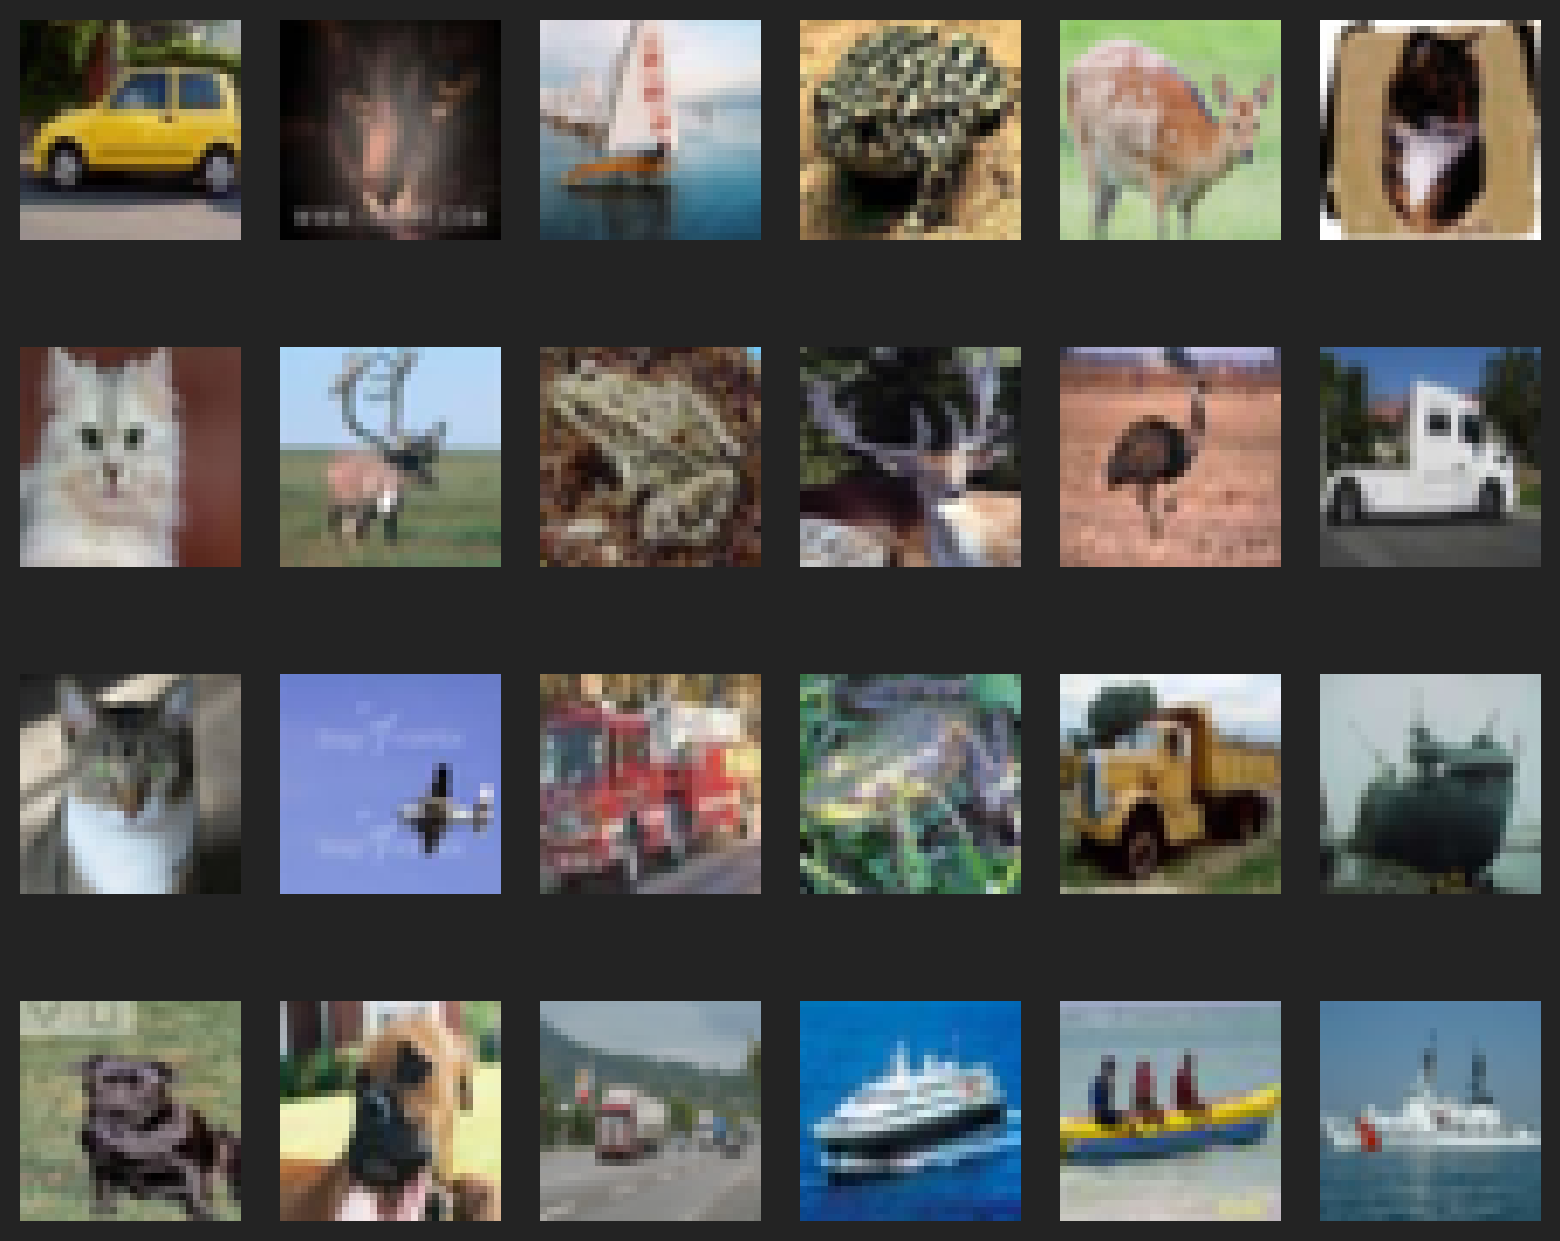

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200)
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img.permute(1,2,0))
        ax.axis('off')
plt.tight_layout()
plt.show()

In [37]:
import torch.nn.functional as F

class Model(torch.nn.Module):

    def __init__(self, n_outputs=10, pretrained=False):
        super().__init__()
        self.backbone = torch.nn.Sequential(*list(torchvision.models.resnet18(pretrained=pretrained).children())[:-1])
        if pretrained:
            for param in self.backbone.parameters():
                param.requires_grad = False
        self.head = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(512, n_outputs)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [38]:
model = Model()
output = model(torch.randn(32, 3, 32, 32))

output.shape

torch.Size([32, 10])

In [39]:
from tqdm import tqdm 

def step(model, batch, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
    return loss, acc

def train(model, dl, optimizer, epochs=10, device="cuda"):
    model.to(device)
    hist = {'loss': [], 'acc': [], 'test_loss': [], 'test_acc': []}
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        for batch in bar:
            optimizer.zero_grad()
            loss, acc = step(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            a.append(acc)
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        # eval
        model.eval()
        l, a = [], []
        bar = tqdm(dl['test'])
        with torch.no_grad():
            for batch in bar:
                loss, acc = step(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                bar.set_description(f"testing... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['test_loss'].append(np.mean(l))
        hist['test_acc'].append(np.mean(a))
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
    return hist

In [40]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

hist = train(model, dl, optimizer, epochs=3)

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 1.5088 acc 0.4568 test_loss 2.1386 test_acc 0.3147


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.0689 acc 0.6151 test_loss 1.2041 test_acc 0.5877


testing... loss 1.1732 acc 0.6032: 100%|██████████| 10/10 [00:01<00:00,  8.97it/s]

Epoch 3/3 loss 0.8552 acc 0.6959 test_loss 1.1732 test_acc 0.6032


In [41]:
import pandas as pd

def plot_hist(hist):
    fig = plt.figure(figsize=(10, 3), dpi=100)
    df = pd.DataFrame(hist)
    ax = plt.subplot(1, 2, 1)
    df[['loss', 'test_loss']].plot(ax=ax)
    ax.grid(True)
    ax = plt.subplot(1, 2, 2)
    df[['acc', 'test_acc']].plot(ax=ax)
    ax.grid(True)
    plt.show()

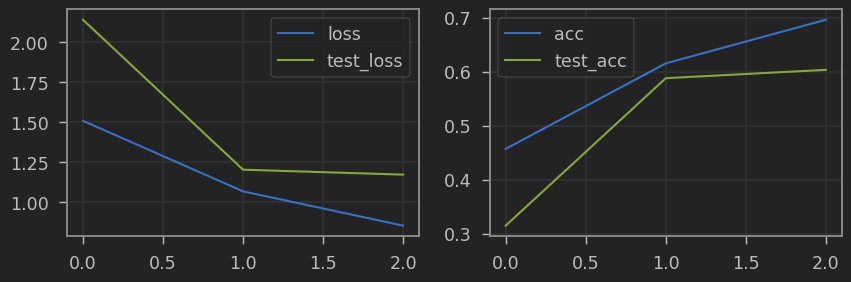

In [42]:
plot_hist(hist)

Tras el entrenmaiento llegamos a una precisión del 70%, lo cual podemos mejorar si entrenamos más *epochs* o con un mejor modelo (pero no es el objetivo de este post). Es importante remarcar que hemos enternado un modelo desde cero, y nuestro dataset consiste de 50000 imágenes de entrenamiento, lo cual no es una cantidad enorme. Sabemos de ejmplos anteriores que podemos usar el *transfer learning* para mejorar estos resultados, usando una red que haya sido pre-entrenada en otro dataset mucho más grande pudiendo aprovechar sus pesos como inicialización para nuestro problema. Lo más normal es utilizar redes pre-entrenada en el dataset Imagenet, ¿pero qué ocurre si nuestro dataset no consiste en imágene naturales o simplemente es muy diferente a Imagenet como es éste caso? Y más importante, ¿qué pasaría si tuviésemos incluso menos ejemplos de los que tenemos? Vamos a ilustrar este caso entrenando el mismo modelo con diferentes porcentajes de ejemplos por cada clase.

In [43]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True, pctg=1.):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.imgs, self.labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
        if pctg < 1.:
            unique_labels = list(range(len(self.classes)))
            filtered_imgs, filtered_labels = [], []
            for lab in unique_labels:
                ixs = (self.labels == lab)
                lim = int(ixs.sum()*pctg)
                filtered_imgs += self.imgs[ixs][:lim].tolist()
                filtered_labels += self.labels[ixs][:lim].tolist()
            self.imgs, self.labels = np.array(filtered_imgs), np.array(filtered_labels)        
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        return torch.from_numpy(img / 255.).permute(2,0,1).float(), torch.tensor(self.labels[ix]).long()

In [44]:
ds = {
    'train': Dataset(pctg=0.01),
    'test': Dataset(train=False)
}

Files already downloaded and verified
Files already downloaded and verified


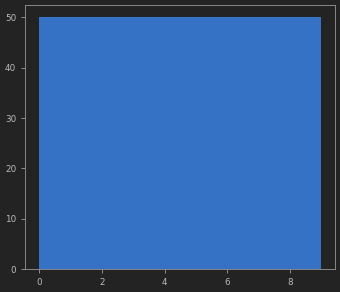

In [45]:
fig, ax = plt.subplots(dpi=50)
ax.hist(ds['train'].labels, bins=10)
plt.show()

In [46]:
pctgs = [0.01, 0.1, 1.]
batch_size = 1024
epochs=3
lr=1e-3
hists = []
for pctg in pctgs:
    ds = {
        'train': Dataset(pctg=pctg),
        'test': Dataset(train=False)
    }
    dl = {
        'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    } 
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = train(model, dl, optimizer, epochs=epochs)
    hists.append(hist)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/3 loss 2.5636 acc 0.0900 test_loss 2.2918 test_acc 0.1177


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/3 loss 1.5218 acc 0.5340 test_loss 2.2998 test_acc 0.1095


testing... loss 2.3001 acc 0.1079: 100%|██████████| 10/10 [00:01<00:00,  9.13it/s]


Epoch 3/3 loss 0.8678 acc 0.8280 test_loss 2.3001 test_acc 0.1079
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/3 loss 2.2472 acc 0.2310 test_loss 2.3309 test_acc 0.0997


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/3 loss 1.5239 acc 0.4519 test_loss 2.5242 test_acc 0.0998


testing... loss 2.7783 acc 0.1072: 100%|██████████| 10/10 [00:01<00:00,  9.18it/s]


Epoch 3/3 loss 1.0692 acc 0.6277 test_loss 2.7783 test_acc 0.1072
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 1.4852 acc 0.4636 test_loss 1.9736 test_acc 0.3617


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.0535 acc 0.6253 test_loss 1.3515 test_acc 0.5382


testing... loss 1.1203 acc 0.6048: 100%|██████████| 10/10 [00:01<00:00,  9.14it/s]

Epoch 3/3 loss 0.8577 acc 0.6954 test_loss 1.1203 test_acc 0.6048


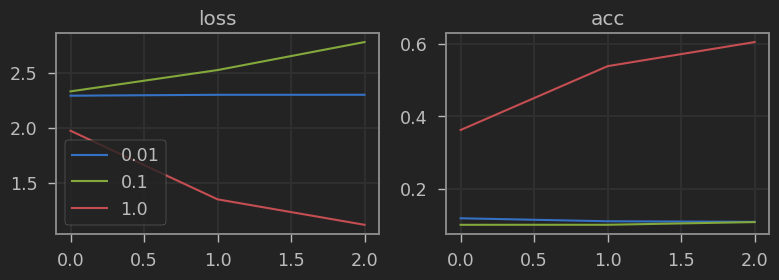

In [47]:
fig = plt.figure(figsize=(8, 3), dpi=100)
ax = plt.subplot(1, 2, 1)
for i, pctg in enumerate(pctgs):
    ax.plot(hists[i]['test_loss'])
ax.grid(True)
ax.legend(pctgs)
ax.set_title('loss')
ax = plt.subplot(1, 2, 2)
for i, pctg in enumerate(pctgs):
    ax.plot(hists[i]['test_acc'])
ax.grid(True)
ax.set_title('acc')
plt.tight_layout()
plt.show()

Como cabría esperar, cuantos más ejemplos de cada clase tengamos en el dataset, mejor resultados obtendremos. Sin embargo, nos gustaría poder tener una mejor eficiencia de datos (tener mejores resultados con menos ejemplos). Para ello, sabemos que necesitamos una red pre-entrenada capaz de extraer buenas características visuales desde el principcio. Vamos a comprar los resultados con una red pre-entrenada en Imagenet.

In [48]:
hists = []
for pctg in pctgs:
    ds = {
        'train': Dataset(pctg=pctg),
        'test': Dataset(train=False)
    }
    dl = {
        'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    } 
    model = Model(pretrained=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = train(model, dl, optimizer, epochs=epochs)
    hists.append(hist)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/3 loss 2.8241 acc 0.1000 test_loss 2.3807 test_acc 0.1021


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/3 loss 2.5952 acc 0.1060 test_loss 2.3522 test_acc 0.1112


testing... loss 2.3340 acc 0.1243: 100%|██████████| 10/10 [00:01<00:00,  9.27it/s]


Epoch 3/3 loss 2.4698 acc 0.0960 test_loss 2.3340 test_acc 0.1243
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/3 loss 2.5440 acc 0.1031 test_loss 2.2951 test_acc 0.1326


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/3 loss 2.3246 acc 0.1669 test_loss 2.2461 test_acc 0.1787


testing... loss 2.1852 acc 0.2241: 100%|██████████| 10/10 [00:01<00:00,  9.19it/s]


Epoch 3/3 loss 2.1528 acc 0.2245 test_loss 2.1852 test_acc 0.2241
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.0244 acc 0.2920 test_loss 1.7801 test_acc 0.3935


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.7012 acc 0.4168 test_loss 1.6779 test_acc 0.4227


testing... loss 1.6328 acc 0.4392: 100%|██████████| 10/10 [00:01<00:00,  9.22it/s]

Epoch 3/3 loss 1.6268 acc 0.4414 test_loss 1.6328 test_acc 0.4392


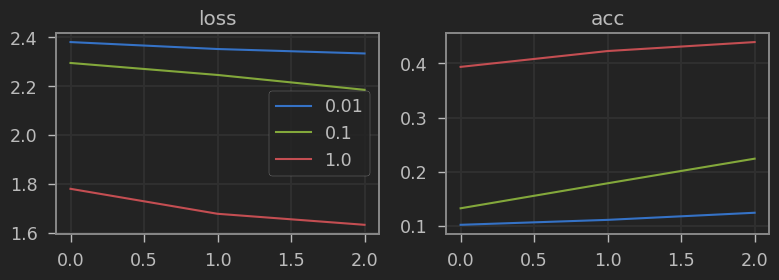

In [49]:
fig = plt.figure(figsize=(8, 3), dpi=100)
ax = plt.subplot(1, 2, 1)
for i, pctg in enumerate(pctgs):
    ax.plot(hists[i]['test_loss'])
ax.grid(True)
ax.legend(pctgs)
ax.set_title('loss')
ax = plt.subplot(1, 2, 2)
for i, pctg in enumerate(pctgs):
    ax.plot(hists[i]['test_acc'])
ax.grid(True)
ax.set_title('acc')
plt.tight_layout()
plt.show()

Nuestra eficiencia ha mejorado, aún así vemos que si usamos el 100% de los datos los resultados empeoran. Para este caso concreto, hacer *fine tuning* de toda la red mejoraría la métrica (usamos la *backbone* congelada para poder comparar con los resultados posteriores). 

Si no queremos (o en función de la aplicación incluso no podremos) usar una red pre-entrenada en Imagenet, tendremos que pre-entrenar una red en imágenes propias de nuestra aplicación (en este caso CIFAR, pero puedes pensar en cualquier otra aplicación) de manera no supervisada. Vamos a implementar un ejemplo usando el método de Barlow Twins.

Lo primero que necesitamos es un dataset que nos de pares de imágenes con diferentes transformaciones. Durante el entrenamiento, calcularemos la salida de nuestro modelo para cada par de imágenes forzando la representación de las mismas a ser iguales. En el caso del método de Barlow Twins, ésto se consigue claculando la matriz de correlación cruzada entre los outputs y haciendo que se acerce lo más posible a la matriz identidad. Puedes ver más detalles en el [artículo](https://arxiv.org/abs/2103.03230) original.

![](bt.png)

In [50]:
import torch
import torchvision

class SSLDataset(torch.utils.data.Dataset):
    def __init__(self, trans):
        self.trans = trans
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        self.imgs = np.array([np.array(i[0]) for i in trainset])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        img1 = self.trans(image=img)['image']
        img2 = self.trans(image=img)['image']
        return torch.from_numpy(img1 / 255.).permute(2,0,1).float(), torch.from_numpy(img2 / 255.).permute(2,0,1).float()

In [75]:
import albumentations as A

trans = A.Compose([
    A.RandomResizedCrop(32, 32),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.3),
    A.ToGray(p=0.3),
    #A.GaussianBlur(),
    A.Solarize(p=0.3)
])

SSLds = SSLDataset(trans)

Files already downloaded and verified


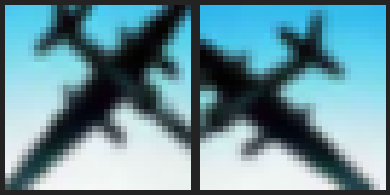

In [109]:
import matplotlib.pyplot as plt
import random

ix = random.randint(0, len(SSLds))
img1, img2 = SSLds[ix]
fig = plt.figure(dpi=50)
ax = plt.subplot(1, 2, 1)
ax.imshow(img1.permute(1,2,0))
ax.axis('off')
ax = plt.subplot(1, 2, 2)
ax.imshow(img2.permute(1,2,0))
ax.axis('off')
plt.tight_layout()
plt.show()

En cuanto al modelo, éste estará formado por una *backbone* (la misma que usarmos más tarde para hacer *fine tuning*) y un perceptrón multicapa con varias capas (que luego tiraremos a la basura ya que solo nos interesa la *bakbone*). 

In [110]:
class SSLModel(torch.nn.Module):

    def __init__(self, f=512):
        super().__init__()
        self.backbone = torch.nn.Sequential(*list(torchvision.models.resnet18().children())[:-1])        
        self.head = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(512, f),
            torch.nn.BatchNorm1d(f),
            torch.nn.ReLU(),
            torch.nn.Linear(f, f),
            torch.nn.BatchNorm1d(f),
            torch.nn.ReLU(),
            torch.nn.Linear(f, f)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [111]:
SSLmodel = SSLModel()
output = SSLmodel(torch.randn(32, 3, 32, 32))

output.shape

torch.Size([32, 512])

Para evaluar el resultado durante el entrenamiento, entrenaremos un nuevo modelo sobre la backbone pre-entrenada de manera supervisada cada cierto número de epochs.

In [112]:
import copy

class FTModel(torch.nn.Module):

    def __init__(self, backbone='SSLbackbone.pt', n_outputs=10):
        super().__init__()
        self.backbone = torch.jit.load(backbone)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.head = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(512, n_outputs)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [116]:
from tqdm import tqdm 

def SSLeval(SSLmodel):
    torch.jit.script(SSLmodel.backbone.cpu()).save('SSLbackbone.pt')
    ds = {
        'train': Dataset(),
        'test': Dataset(train=False)
    }
    batch_size = 1024
    dl = {
        'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    } 
    FTmodel = FTModel('SSLbackbone.pt')
    optimizer = torch.optim.Adam(FTmodel.parameters(), lr=1e-3)
    hist = train(FTmodel, dl, optimizer, epochs=3)
    return hist['acc'][-1], hist['test_acc'][-1]

def SSLstep(model, batch, device, l=5e-3):
    # two randomly augmented versions of x
    x1, x2 = batch
    x1, x2 = x1.to(device), x2.to(device)
    
    # compute representations
    z1 = model(x1)
    z2 = model(x2)
    
    # normalize repr. along the batch dimension
    N, D = z1.shape
    z1_norm = (z1 - z1.mean(0)) / z1.std(0) # NxD
    z2_norm = (z2 - z2.mean(0)) / z2.std(0) # NxD
    
    # cross-correlation matrix
    c = (z1_norm.T @ z2_norm) / N # DxD
    
    # loss
    c_diff = (c - torch.eye(D, device=device)).pow(2) # DxD
    # multiply off-diagonal elems of c_diff by lambda
    d = torch.eye(D, dtype=bool)
    c_diff[~d] *= l
    return c_diff.sum()

def SSLtrain(model, dl, optimizer, scheduler, epochs=10, device="cuda", eval_each=10):
    hist = {'loss': [], 'acc': [], 'test_acc': []}
    for e in range(1, epochs+1):
        model.to(device)
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl)
        for batch in bar:
            optimizer.zero_grad()
            loss = SSLstep(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            bar.set_description(f"training... loss {np.mean(l):.4f}")
        hist['loss'].append(np.mean(l))
        scheduler.step()
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            if len(v) > 0:
                log += f' {k} {v[-1]:.4f}'
        print(log)
        # eval
        if not e % eval_each:
            print("evaluating ...")
            val_train_acc, val_test_acc = SSLeval(model)
            hist['acc'].append(val_train_acc)
            hist['test_acc'].append(val_test_acc)
    return hist

In [117]:
SSLdl = torch.utils.data.DataLoader(SSLds, batch_size=1024, shuffle=True, num_workers=num_workers)
SSLmodel = SSLModel()
optimizer = torch.optim.Adam(SSLmodel.parameters(), lr=1e-4)
epochs = 500
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, pct_start=0.01, max_lr=0.1, total_steps=epochs, verbose=True)
hist = SSLtrain(SSLmodel, SSLdl, optimizer, scheduler, epochs=epochs)

  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0000e-03.


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8059e-02.
Epoch 1/500 loss 234.3495


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.2000e-02.
Epoch 2/500 loss 186.7790


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.5941e-02.
Epoch 3/500 loss 168.2400


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 4/500 loss 158.0354


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9999e-02.
Epoch 5/500 loss 150.5545


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9996e-02.
Epoch 6/500 loss 144.7236


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9991e-02.
Epoch 7/500 loss 139.4622


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9984e-02.
Epoch 8/500 loss 133.0226


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9975e-02.
Epoch 9/500 loss 126.0350


training... loss 122.4021: 100%|██████████| 49/49 [00:05<00:00,  8.19it/s]


Adjusting learning rate of group 0 to 9.9964e-02.
Epoch 10/500 loss 122.4021
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.0185 acc 0.2734 test_loss 1.7894 test_acc 0.3367


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.7709 acc 0.3417 test_loss 1.7640 test_acc 0.3468


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.7561 acc 0.3473 test_loss 1.7562 test_acc 0.3462


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9951e-02.
Epoch 11/500 loss 121.1789 acc 0.3473 test_acc 0.3462


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9936e-02.
Epoch 12/500 loss 116.8929 acc 0.3473 test_acc 0.3462


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9918e-02.
Epoch 13/500 loss 117.5452 acc 0.3473 test_acc 0.3462


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9899e-02.
Epoch 14/500 loss 112.7781 acc 0.3473 test_acc 0.3462


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9878e-02.
Epoch 15/500 loss 111.7623 acc 0.3473 test_acc 0.3462


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9855e-02.
Epoch 16/500 loss 108.3251 acc 0.3473 test_acc 0.3462


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9830e-02.
Epoch 17/500 loss 108.5791 acc 0.3473 test_acc 0.3462


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9803e-02.
Epoch 18/500 loss 107.7422 acc 0.3473 test_acc 0.3462


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9774e-02.
Epoch 19/500 loss 103.8399 acc 0.3473 test_acc 0.3462


training... loss 103.8034: 100%|██████████| 49/49 [00:05<00:00,  8.19it/s]


Adjusting learning rate of group 0 to 9.9742e-02.
Epoch 20/500 loss 103.8034 acc 0.3473 test_acc 0.3462
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.0624 acc 0.2815 test_loss 1.7363 test_acc 0.3676


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.7104 acc 0.3673 test_loss 1.6816 test_acc 0.3842


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.6766 acc 0.3813 test_loss 1.6617 test_acc 0.3936


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9709e-02.
Epoch 21/500 loss 103.0495 acc 0.3813 test_acc 0.3936


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9674e-02.
Epoch 22/500 loss 102.3072 acc 0.3813 test_acc 0.3936


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9637e-02.
Epoch 23/500 loss 102.3508 acc 0.3813 test_acc 0.3936


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9598e-02.
Epoch 24/500 loss 100.6684 acc 0.3813 test_acc 0.3936


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9557e-02.
Epoch 25/500 loss 99.9482 acc 0.3813 test_acc 0.3936


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9513e-02.
Epoch 26/500 loss 100.0503 acc 0.3813 test_acc 0.3936


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9468e-02.
Epoch 27/500 loss 96.8635 acc 0.3813 test_acc 0.3936


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9421e-02.
Epoch 28/500 loss 96.4061 acc 0.3813 test_acc 0.3936


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9372e-02.
Epoch 29/500 loss 97.3839 acc 0.3813 test_acc 0.3936


training... loss 94.8187: 100%|██████████| 49/49 [00:05<00:00,  8.20it/s]


Adjusting learning rate of group 0 to 9.9321e-02.
Epoch 30/500 loss 94.8187 acc 0.3813 test_acc 0.3936
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 1.9966 acc 0.3007 test_loss 1.7174 test_acc 0.3682


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.6672 acc 0.3845 test_loss 1.6503 test_acc 0.3928


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.6307 acc 0.4006 test_loss 1.6259 test_acc 0.4009


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9268e-02.
Epoch 31/500 loss 95.6163 acc 0.4006 test_acc 0.4009


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9213e-02.
Epoch 32/500 loss 94.4829 acc 0.4006 test_acc 0.4009


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9156e-02.
Epoch 33/500 loss 93.9791 acc 0.4006 test_acc 0.4009


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9096e-02.
Epoch 34/500 loss 93.0858 acc 0.4006 test_acc 0.4009


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9035e-02.
Epoch 35/500 loss 92.1114 acc 0.4006 test_acc 0.4009


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8972e-02.
Epoch 36/500 loss 91.7867 acc 0.4006 test_acc 0.4009


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8907e-02.
Epoch 37/500 loss 90.7298 acc 0.4006 test_acc 0.4009


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8840e-02.
Epoch 38/500 loss 89.3234 acc 0.4006 test_acc 0.4009


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8771e-02.
Epoch 39/500 loss 89.9686 acc 0.4006 test_acc 0.4009


training... loss 90.4925: 100%|██████████| 49/49 [00:05<00:00,  8.21it/s]


Adjusting learning rate of group 0 to 9.8701e-02.
Epoch 40/500 loss 90.4925 acc 0.4006 test_acc 0.4009
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.0405 acc 0.3026 test_loss 1.6555 test_acc 0.3964


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.6088 acc 0.4082 test_loss 1.6052 test_acc 0.4159


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.5700 acc 0.4269 test_loss 1.5713 test_acc 0.4338


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8628e-02.
Epoch 41/500 loss 89.5281 acc 0.4269 test_acc 0.4338


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8553e-02.
Epoch 42/500 loss 87.8652 acc 0.4269 test_acc 0.4338


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8476e-02.
Epoch 43/500 loss 87.8886 acc 0.4269 test_acc 0.4338


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8397e-02.
Epoch 44/500 loss 87.7545 acc 0.4269 test_acc 0.4338


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8317e-02.
Epoch 45/500 loss 86.4574 acc 0.4269 test_acc 0.4338


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8234e-02.
Epoch 46/500 loss 87.3032 acc 0.4269 test_acc 0.4338


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8150e-02.
Epoch 47/500 loss 85.1622 acc 0.4269 test_acc 0.4338


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8063e-02.
Epoch 48/500 loss 85.6648 acc 0.4269 test_acc 0.4338


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.7975e-02.
Epoch 49/500 loss 84.2545 acc 0.4269 test_acc 0.4338


training... loss 85.1285: 100%|██████████| 49/49 [00:05<00:00,  8.17it/s]


Adjusting learning rate of group 0 to 9.7884e-02.
Epoch 50/500 loss 85.1285 acc 0.4269 test_acc 0.4338
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.4439 acc 0.2882 test_loss 1.6385 test_acc 0.4005


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.5643 acc 0.4254 test_loss 1.5479 test_acc 0.4302


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.5136 acc 0.4423 test_loss 1.5087 test_acc 0.4434


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.7792e-02.
Epoch 51/500 loss 82.7136 acc 0.4423 test_acc 0.4434


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.7698e-02.
Epoch 52/500 loss 83.2338 acc 0.4423 test_acc 0.4434


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.7602e-02.
Epoch 53/500 loss 82.4877 acc 0.4423 test_acc 0.4434


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.7504e-02.
Epoch 54/500 loss 82.8856 acc 0.4423 test_acc 0.4434


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.7404e-02.
Epoch 55/500 loss 82.3083 acc 0.4423 test_acc 0.4434


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.7302e-02.
Epoch 56/500 loss 81.7923 acc 0.4423 test_acc 0.4434


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.7198e-02.
Epoch 57/500 loss 81.5943 acc 0.4423 test_acc 0.4434


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.7092e-02.
Epoch 58/500 loss 80.9346 acc 0.4423 test_acc 0.4434


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.6985e-02.
Epoch 59/500 loss 82.2090 acc 0.4423 test_acc 0.4434


training... loss 80.4593: 100%|██████████| 49/49 [00:05<00:00,  8.28it/s]


Adjusting learning rate of group 0 to 9.6875e-02.
Epoch 60/500 loss 80.4593 acc 0.4423 test_acc 0.4434
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 1.9314 acc 0.3557 test_loss 1.5348 test_acc 0.4414


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.4880 acc 0.4527 test_loss 1.4921 test_acc 0.4561


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.4550 acc 0.4686 test_loss 1.4543 test_acc 0.4703


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.6764e-02.
Epoch 61/500 loss 80.2005 acc 0.4686 test_acc 0.4703


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.6651e-02.
Epoch 62/500 loss 80.6315 acc 0.4686 test_acc 0.4703


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.6535e-02.
Epoch 63/500 loss 79.7051 acc 0.4686 test_acc 0.4703


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.6418e-02.
Epoch 64/500 loss 79.5373 acc 0.4686 test_acc 0.4703


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.6300e-02.
Epoch 65/500 loss 78.2155 acc 0.4686 test_acc 0.4703


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.6179e-02.
Epoch 66/500 loss 79.0451 acc 0.4686 test_acc 0.4703


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.6056e-02.
Epoch 67/500 loss 78.0187 acc 0.4686 test_acc 0.4703


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.5932e-02.
Epoch 68/500 loss 76.5776 acc 0.4686 test_acc 0.4703


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.5805e-02.
Epoch 69/500 loss 77.9876 acc 0.4686 test_acc 0.4703


training... loss 76.9581: 100%|██████████| 49/49 [00:05<00:00,  8.28it/s]


Adjusting learning rate of group 0 to 9.5677e-02.
Epoch 70/500 loss 76.9581 acc 0.4686 test_acc 0.4703
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.5283 acc 0.3040 test_loss 1.5859 test_acc 0.4322


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.4869 acc 0.4516 test_loss 1.4663 test_acc 0.4640


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.4186 acc 0.4780 test_loss 1.4268 test_acc 0.4729


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.5547e-02.
Epoch 71/500 loss 76.6947 acc 0.4780 test_acc 0.4729


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.5415e-02.
Epoch 72/500 loss 76.4860 acc 0.4780 test_acc 0.4729


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.5282e-02.
Epoch 73/500 loss 75.6979 acc 0.4780 test_acc 0.4729


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.5146e-02.
Epoch 74/500 loss 76.8974 acc 0.4780 test_acc 0.4729


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.5009e-02.
Epoch 75/500 loss 74.0634 acc 0.4780 test_acc 0.4729


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.4870e-02.
Epoch 76/500 loss 75.2467 acc 0.4780 test_acc 0.4729


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.4729e-02.
Epoch 77/500 loss 75.7896 acc 0.4780 test_acc 0.4729


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.4586e-02.
Epoch 78/500 loss 74.3384 acc 0.4780 test_acc 0.4729


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.4442e-02.
Epoch 79/500 loss 74.3234 acc 0.4780 test_acc 0.4729


training... loss 73.7727: 100%|██████████| 49/49 [00:05<00:00,  8.31it/s]


Adjusting learning rate of group 0 to 9.4295e-02.
Epoch 80/500 loss 73.7727 acc 0.4780 test_acc 0.4729
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.5852 acc 0.3123 test_loss 1.5604 test_acc 0.4331


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.4739 acc 0.4553 test_loss 1.4495 test_acc 0.4676


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.4156 acc 0.4785 test_loss 1.4137 test_acc 0.4817


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.4147e-02.
Epoch 81/500 loss 72.5154 acc 0.4785 test_acc 0.4817


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.3998e-02.
Epoch 82/500 loss 73.6568 acc 0.4785 test_acc 0.4817


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.3846e-02.
Epoch 83/500 loss 73.6969 acc 0.4785 test_acc 0.4817


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.3692e-02.
Epoch 84/500 loss 73.1727 acc 0.4785 test_acc 0.4817


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.3537e-02.
Epoch 85/500 loss 74.5992 acc 0.4785 test_acc 0.4817


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.3380e-02.
Epoch 86/500 loss 73.2047 acc 0.4785 test_acc 0.4817


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.3222e-02.
Epoch 87/500 loss 72.0910 acc 0.4785 test_acc 0.4817


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.3061e-02.
Epoch 88/500 loss 72.7790 acc 0.4785 test_acc 0.4817


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.2899e-02.
Epoch 89/500 loss 73.2399 acc 0.4785 test_acc 0.4817


training... loss 71.5261: 100%|██████████| 49/49 [00:05<00:00,  8.21it/s]


Adjusting learning rate of group 0 to 9.2735e-02.
Epoch 90/500 loss 71.5261 acc 0.4785 test_acc 0.4817
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.1647 acc 0.3473 test_loss 1.5071 test_acc 0.4702


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.4402 acc 0.4803 test_loss 1.3955 test_acc 0.4934


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.3911 acc 0.4955 test_loss 1.3868 test_acc 0.4899


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.2570e-02.
Epoch 91/500 loss 71.7446 acc 0.4955 test_acc 0.4899


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.2402e-02.
Epoch 92/500 loss 71.8199 acc 0.4955 test_acc 0.4899


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.2233e-02.
Epoch 93/500 loss 70.5188 acc 0.4955 test_acc 0.4899


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.2063e-02.
Epoch 94/500 loss 72.0299 acc 0.4955 test_acc 0.4899


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.1890e-02.
Epoch 95/500 loss 71.2043 acc 0.4955 test_acc 0.4899


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.1716e-02.
Epoch 96/500 loss 71.9969 acc 0.4955 test_acc 0.4899


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.1540e-02.
Epoch 97/500 loss 70.2895 acc 0.4955 test_acc 0.4899


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.1363e-02.
Epoch 98/500 loss 70.0398 acc 0.4955 test_acc 0.4899


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.1184e-02.
Epoch 99/500 loss 69.5775 acc 0.4955 test_acc 0.4899


training... loss 70.8453: 100%|██████████| 49/49 [00:05<00:00,  8.25it/s]


Adjusting learning rate of group 0 to 9.1003e-02.
Epoch 100/500 loss 70.8453 acc 0.4955 test_acc 0.4899
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.5526 acc 0.3214 test_loss 1.5392 test_acc 0.4646


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.4447 acc 0.4840 test_loss 1.4159 test_acc 0.4953


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.3805 acc 0.5014 test_loss 1.3815 test_acc 0.5016


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.0821e-02.
Epoch 101/500 loss 68.6175 acc 0.5014 test_acc 0.5016


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.0637e-02.
Epoch 102/500 loss 70.1022 acc 0.5014 test_acc 0.5016


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.0451e-02.
Epoch 103/500 loss 68.5639 acc 0.5014 test_acc 0.5016


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.0264e-02.
Epoch 104/500 loss 68.3681 acc 0.5014 test_acc 0.5016


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.0075e-02.
Epoch 105/500 loss 68.6905 acc 0.5014 test_acc 0.5016


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.9884e-02.
Epoch 106/500 loss 69.3610 acc 0.5014 test_acc 0.5016


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.9692e-02.
Epoch 107/500 loss 67.8597 acc 0.5014 test_acc 0.5016


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.9498e-02.
Epoch 108/500 loss 69.0299 acc 0.5014 test_acc 0.5016


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.9303e-02.
Epoch 109/500 loss 67.8908 acc 0.5014 test_acc 0.5016


training... loss 67.9712: 100%|██████████| 49/49 [00:06<00:00,  8.11it/s]


Adjusting learning rate of group 0 to 8.9106e-02.
Epoch 110/500 loss 67.9712 acc 0.5014 test_acc 0.5016
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.4168 acc 0.3496 test_loss 1.5245 test_acc 0.4626


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.4337 acc 0.4861 test_loss 1.4133 test_acc 0.4918


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.3712 acc 0.5020 test_loss 1.3721 test_acc 0.5075


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.8907e-02.
Epoch 111/500 loss 68.4253 acc 0.5020 test_acc 0.5075


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.8707e-02.
Epoch 112/500 loss 68.2919 acc 0.5020 test_acc 0.5075


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.8505e-02.
Epoch 113/500 loss 67.6719 acc 0.5020 test_acc 0.5075


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.8302e-02.
Epoch 114/500 loss 67.6514 acc 0.5020 test_acc 0.5075


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.8098e-02.
Epoch 115/500 loss 67.9290 acc 0.5020 test_acc 0.5075


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.7891e-02.
Epoch 116/500 loss 67.3860 acc 0.5020 test_acc 0.5075


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.7683e-02.
Epoch 117/500 loss 68.1966 acc 0.5020 test_acc 0.5075


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.7474e-02.
Epoch 118/500 loss 67.0600 acc 0.5020 test_acc 0.5075


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.7263e-02.
Epoch 119/500 loss 65.9603 acc 0.5020 test_acc 0.5075


training... loss 67.0259: 100%|██████████| 49/49 [00:06<00:00,  8.14it/s]


Adjusting learning rate of group 0 to 8.7051e-02.
Epoch 120/500 loss 67.0259 acc 0.5020 test_acc 0.5075
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.4035 acc 0.3550 test_loss 1.5039 test_acc 0.4779


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.4207 acc 0.4918 test_loss 1.3905 test_acc 0.4967


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.3435 acc 0.5100 test_loss 1.3311 test_acc 0.5199


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.6837e-02.
Epoch 121/500 loss 67.0043 acc 0.5100 test_acc 0.5199


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.6622e-02.
Epoch 122/500 loss 65.6470 acc 0.5100 test_acc 0.5199


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.6405e-02.
Epoch 123/500 loss 66.3844 acc 0.5100 test_acc 0.5199


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.6187e-02.
Epoch 124/500 loss 66.0165 acc 0.5100 test_acc 0.5199


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.5967e-02.
Epoch 125/500 loss 66.0738 acc 0.5100 test_acc 0.5199


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.5746e-02.
Epoch 126/500 loss 65.6746 acc 0.5100 test_acc 0.5199


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.5523e-02.
Epoch 127/500 loss 66.1963 acc 0.5100 test_acc 0.5199


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.5299e-02.
Epoch 128/500 loss 66.0198 acc 0.5100 test_acc 0.5199


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.5074e-02.
Epoch 129/500 loss 65.7775 acc 0.5100 test_acc 0.5199


training... loss 65.5017: 100%|██████████| 49/49 [00:05<00:00,  8.18it/s]


Adjusting learning rate of group 0 to 8.4847e-02.
Epoch 130/500 loss 65.5017 acc 0.5100 test_acc 0.5199
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.2382 acc 0.3725 test_loss 1.4853 test_acc 0.4930


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3950 acc 0.5062 test_loss 1.3742 test_acc 0.5078


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.3273 acc 0.5224 test_loss 1.3348 test_acc 0.5226


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.4619e-02.
Epoch 131/500 loss 64.4712 acc 0.5224 test_acc 0.5226


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.4389e-02.
Epoch 132/500 loss 65.1404 acc 0.5224 test_acc 0.5226


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.4158e-02.
Epoch 133/500 loss 64.9171 acc 0.5224 test_acc 0.5226


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.3926e-02.
Epoch 134/500 loss 64.6344 acc 0.5224 test_acc 0.5226


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.3692e-02.
Epoch 135/500 loss 65.6417 acc 0.5224 test_acc 0.5226


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.3457e-02.
Epoch 136/500 loss 64.9643 acc 0.5224 test_acc 0.5226


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.3220e-02.
Epoch 137/500 loss 64.1484 acc 0.5224 test_acc 0.5226


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.2982e-02.
Epoch 138/500 loss 66.1567 acc 0.5224 test_acc 0.5226


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.2743e-02.
Epoch 139/500 loss 64.3982 acc 0.5224 test_acc 0.5226


training... loss 64.8770: 100%|██████████| 49/49 [00:06<00:00,  8.08it/s]


Adjusting learning rate of group 0 to 8.2503e-02.
Epoch 140/500 loss 64.8770 acc 0.5224 test_acc 0.5226
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.1255 acc 0.3354 test_loss 1.5394 test_acc 0.4881


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.4284 acc 0.5049 test_loss 1.3734 test_acc 0.5168


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.3304 acc 0.5251 test_loss 1.3204 test_acc 0.5271


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.2261e-02.
Epoch 141/500 loss 64.1353 acc 0.5251 test_acc 0.5271


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.2018e-02.
Epoch 142/500 loss 64.6744 acc 0.5251 test_acc 0.5271


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.1773e-02.
Epoch 143/500 loss 64.9246 acc 0.5251 test_acc 0.5271


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.1528e-02.
Epoch 144/500 loss 65.5898 acc 0.5251 test_acc 0.5271


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.1281e-02.
Epoch 145/500 loss 63.1039 acc 0.5251 test_acc 0.5271


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.1033e-02.
Epoch 146/500 loss 62.7623 acc 0.5251 test_acc 0.5271


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.0783e-02.
Epoch 147/500 loss 63.5125 acc 0.5251 test_acc 0.5271


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.0532e-02.
Epoch 148/500 loss 63.1521 acc 0.5251 test_acc 0.5271


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.0281e-02.
Epoch 149/500 loss 63.2084 acc 0.5251 test_acc 0.5271


training... loss 63.2908: 100%|██████████| 49/49 [00:06<00:00,  8.05it/s]


Adjusting learning rate of group 0 to 8.0027e-02.
Epoch 150/500 loss 63.2908 acc 0.5251 test_acc 0.5271
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.5857 acc 0.3668 test_loss 1.5283 test_acc 0.4990


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.4028 acc 0.5113 test_loss 1.3677 test_acc 0.5254


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.3149 acc 0.5304 test_loss 1.3097 test_acc 0.5354


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.9773e-02.
Epoch 151/500 loss 62.6693 acc 0.5304 test_acc 0.5354


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.9518e-02.
Epoch 152/500 loss 62.9232 acc 0.5304 test_acc 0.5354


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.9261e-02.
Epoch 153/500 loss 61.5043 acc 0.5304 test_acc 0.5354


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.9003e-02.
Epoch 154/500 loss 63.0614 acc 0.5304 test_acc 0.5354


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.8744e-02.
Epoch 155/500 loss 64.2113 acc 0.5304 test_acc 0.5354


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.8484e-02.
Epoch 156/500 loss 63.4854 acc 0.5304 test_acc 0.5354


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.8222e-02.
Epoch 157/500 loss 62.9709 acc 0.5304 test_acc 0.5354


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.7960e-02.
Epoch 158/500 loss 61.2057 acc 0.5304 test_acc 0.5354


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.7696e-02.
Epoch 159/500 loss 61.8889 acc 0.5304 test_acc 0.5354


training... loss 61.8192: 100%|██████████| 49/49 [00:06<00:00,  8.11it/s]


Adjusting learning rate of group 0 to 7.7431e-02.
Epoch 160/500 loss 61.8192 acc 0.5304 test_acc 0.5354
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.7576 acc 0.3566 test_loss 1.5847 test_acc 0.4933


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.4538 acc 0.5076 test_loss 1.3700 test_acc 0.5160


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.3328 acc 0.5271 test_loss 1.3136 test_acc 0.5296


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.7165e-02.
Epoch 161/500 loss 62.3800 acc 0.5271 test_acc 0.5296


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.6899e-02.
Epoch 162/500 loss 61.7315 acc 0.5271 test_acc 0.5296


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.6630e-02.
Epoch 163/500 loss 61.2536 acc 0.5271 test_acc 0.5296


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.6361e-02.
Epoch 164/500 loss 61.3215 acc 0.5271 test_acc 0.5296


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.6091e-02.
Epoch 165/500 loss 59.6125 acc 0.5271 test_acc 0.5296


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.5820e-02.
Epoch 166/500 loss 61.4655 acc 0.5271 test_acc 0.5296


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.5548e-02.
Epoch 167/500 loss 60.8598 acc 0.5271 test_acc 0.5296


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.5274e-02.
Epoch 168/500 loss 61.2477 acc 0.5271 test_acc 0.5296


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.5000e-02.
Epoch 169/500 loss 60.3787 acc 0.5271 test_acc 0.5296


training... loss 61.2026: 100%|██████████| 49/49 [00:06<00:00,  8.14it/s]


Adjusting learning rate of group 0 to 7.4725e-02.
Epoch 170/500 loss 61.2026 acc 0.5271 test_acc 0.5296
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.6600 acc 0.3669 test_loss 1.5067 test_acc 0.5056


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3834 acc 0.5210 test_loss 1.3423 test_acc 0.5291


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.2942 acc 0.5395 test_loss 1.2908 test_acc 0.5410


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.4448e-02.
Epoch 171/500 loss 61.4451 acc 0.5395 test_acc 0.5410


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.4171e-02.
Epoch 172/500 loss 59.9385 acc 0.5395 test_acc 0.5410


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.3893e-02.
Epoch 173/500 loss 60.2823 acc 0.5395 test_acc 0.5410


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.3614e-02.
Epoch 174/500 loss 59.6920 acc 0.5395 test_acc 0.5410


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.3333e-02.
Epoch 175/500 loss 61.7279 acc 0.5395 test_acc 0.5410


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.3052e-02.
Epoch 176/500 loss 58.7893 acc 0.5395 test_acc 0.5410


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.2770e-02.
Epoch 177/500 loss 61.0146 acc 0.5395 test_acc 0.5410


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.2487e-02.
Epoch 178/500 loss 59.4459 acc 0.5395 test_acc 0.5410


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.2203e-02.
Epoch 179/500 loss 59.0519 acc 0.5395 test_acc 0.5410


training... loss 58.4757: 100%|██████████| 49/49 [00:06<00:00,  8.02it/s]


Adjusting learning rate of group 0 to 7.1919e-02.
Epoch 180/500 loss 58.4757 acc 0.5395 test_acc 0.5410
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.2120 acc 0.3301 test_loss 1.5594 test_acc 0.4972


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.4131 acc 0.5223 test_loss 1.3552 test_acc 0.5296


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.3019 acc 0.5445 test_loss 1.2881 test_acc 0.5449


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.1633e-02.
Epoch 181/500 loss 59.3194 acc 0.5445 test_acc 0.5449


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.1346e-02.
Epoch 182/500 loss 60.2154 acc 0.5445 test_acc 0.5449


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.1059e-02.
Epoch 183/500 loss 60.0990 acc 0.5445 test_acc 0.5449


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0771e-02.
Epoch 184/500 loss 58.6610 acc 0.5445 test_acc 0.5449


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0482e-02.
Epoch 185/500 loss 58.2290 acc 0.5445 test_acc 0.5449


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0192e-02.
Epoch 186/500 loss 59.4822 acc 0.5445 test_acc 0.5449


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.9901e-02.
Epoch 187/500 loss 57.8018 acc 0.5445 test_acc 0.5449


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.9610e-02.
Epoch 188/500 loss 57.4029 acc 0.5445 test_acc 0.5449


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.9317e-02.
Epoch 189/500 loss 58.5110 acc 0.5445 test_acc 0.5449


training... loss 59.8349: 100%|██████████| 49/49 [00:06<00:00,  8.14it/s]


Adjusting learning rate of group 0 to 6.9024e-02.
Epoch 190/500 loss 59.8349 acc 0.5445 test_acc 0.5449
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.1209 acc 0.3607 test_loss 1.4914 test_acc 0.5123


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3753 acc 0.5311 test_loss 1.3136 test_acc 0.5436


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.2705 acc 0.5537 test_loss 1.2613 test_acc 0.5552


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.8730e-02.
Epoch 191/500 loss 58.7368 acc 0.5537 test_acc 0.5552


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.8436e-02.
Epoch 192/500 loss 59.7530 acc 0.5537 test_acc 0.5552


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.8141e-02.
Epoch 193/500 loss 56.5191 acc 0.5537 test_acc 0.5552


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.7844e-02.
Epoch 194/500 loss 58.9744 acc 0.5537 test_acc 0.5552


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.7548e-02.
Epoch 195/500 loss 57.6280 acc 0.5537 test_acc 0.5552


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.7250e-02.
Epoch 196/500 loss 57.2137 acc 0.5537 test_acc 0.5552


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.6952e-02.
Epoch 197/500 loss 57.9601 acc 0.5537 test_acc 0.5552


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.6653e-02.
Epoch 198/500 loss 59.2608 acc 0.5537 test_acc 0.5552


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.6354e-02.
Epoch 199/500 loss 57.9956 acc 0.5537 test_acc 0.5552


training... loss 58.3618: 100%|██████████| 49/49 [00:05<00:00,  8.18it/s]


Adjusting learning rate of group 0 to 6.6053e-02.
Epoch 200/500 loss 58.3618 acc 0.5537 test_acc 0.5552
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.0268 acc 0.3480 test_loss 1.5109 test_acc 0.5136


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3918 acc 0.5294 test_loss 1.3620 test_acc 0.5281


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.2900 acc 0.5474 test_loss 1.2896 test_acc 0.5457


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.5752e-02.
Epoch 201/500 loss 57.5442 acc 0.5474 test_acc 0.5457


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.5451e-02.
Epoch 202/500 loss 56.9155 acc 0.5474 test_acc 0.5457


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.5149e-02.
Epoch 203/500 loss 57.1067 acc 0.5474 test_acc 0.5457


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4846e-02.
Epoch 204/500 loss 58.8273 acc 0.5474 test_acc 0.5457


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4543e-02.
Epoch 205/500 loss 58.2340 acc 0.5474 test_acc 0.5457


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4239e-02.
Epoch 206/500 loss 57.2095 acc 0.5474 test_acc 0.5457


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.3934e-02.
Epoch 207/500 loss 55.9994 acc 0.5474 test_acc 0.5457


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.3629e-02.
Epoch 208/500 loss 55.6396 acc 0.5474 test_acc 0.5457


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.3324e-02.
Epoch 209/500 loss 56.9057 acc 0.5474 test_acc 0.5457


training... loss 55.8449: 100%|██████████| 49/49 [00:06<00:00,  8.06it/s]


Adjusting learning rate of group 0 to 6.3018e-02.
Epoch 210/500 loss 55.8449 acc 0.5474 test_acc 0.5457
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.5816 acc 0.3768 test_loss 1.4628 test_acc 0.5085


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3500 acc 0.5369 test_loss 1.3356 test_acc 0.5329


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.2646 acc 0.5554 test_loss 1.2619 test_acc 0.5557


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2711e-02.
Epoch 211/500 loss 57.1751 acc 0.5554 test_acc 0.5557


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2404e-02.
Epoch 212/500 loss 56.1403 acc 0.5554 test_acc 0.5557


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2096e-02.
Epoch 213/500 loss 56.8282 acc 0.5554 test_acc 0.5557


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.1788e-02.
Epoch 214/500 loss 56.3215 acc 0.5554 test_acc 0.5557


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.1479e-02.
Epoch 215/500 loss 55.6677 acc 0.5554 test_acc 0.5557


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.1170e-02.
Epoch 216/500 loss 56.4575 acc 0.5554 test_acc 0.5557


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.0861e-02.
Epoch 217/500 loss 54.6877 acc 0.5554 test_acc 0.5557


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.0551e-02.
Epoch 218/500 loss 56.7154 acc 0.5554 test_acc 0.5557


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.0240e-02.
Epoch 219/500 loss 54.8166 acc 0.5554 test_acc 0.5557


training... loss 57.0527: 100%|██████████| 49/49 [00:06<00:00,  7.89it/s]


Adjusting learning rate of group 0 to 5.9930e-02.
Epoch 220/500 loss 57.0527 acc 0.5554 test_acc 0.5557
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.0738 acc 0.3356 test_loss 1.5165 test_acc 0.5175


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3845 acc 0.5388 test_loss 1.3181 test_acc 0.5500


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.2676 acc 0.5584 test_loss 1.2563 test_acc 0.5622


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.9618e-02.
Epoch 221/500 loss 54.6305 acc 0.5584 test_acc 0.5622


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.9307e-02.
Epoch 222/500 loss 55.0682 acc 0.5584 test_acc 0.5622


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.8995e-02.
Epoch 223/500 loss 55.0366 acc 0.5584 test_acc 0.5622


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.8683e-02.
Epoch 224/500 loss 54.6251 acc 0.5584 test_acc 0.5622


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.8370e-02.
Epoch 225/500 loss 55.0811 acc 0.5584 test_acc 0.5622


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.8057e-02.
Epoch 226/500 loss 55.2068 acc 0.5584 test_acc 0.5622


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.7744e-02.
Epoch 227/500 loss 55.1480 acc 0.5584 test_acc 0.5622


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.7430e-02.
Epoch 228/500 loss 53.5885 acc 0.5584 test_acc 0.5622


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.7116e-02.
Epoch 229/500 loss 55.2435 acc 0.5584 test_acc 0.5622


training... loss 55.1587: 100%|██████████| 49/49 [00:06<00:00,  8.08it/s]


Adjusting learning rate of group 0 to 5.6802e-02.
Epoch 230/500 loss 55.1587 acc 0.5584 test_acc 0.5622
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.3020 acc 0.3451 test_loss 1.5390 test_acc 0.5131


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3790 acc 0.5382 test_loss 1.3143 test_acc 0.5498


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.2565 acc 0.5638 test_loss 1.2541 test_acc 0.5634


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6487e-02.
Epoch 231/500 loss 53.2126 acc 0.5638 test_acc 0.5634


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6172e-02.
Epoch 232/500 loss 55.0603 acc 0.5638 test_acc 0.5634


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.5857e-02.
Epoch 233/500 loss 55.1624 acc 0.5638 test_acc 0.5634


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.5542e-02.
Epoch 234/500 loss 53.6615 acc 0.5638 test_acc 0.5634


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.5227e-02.
Epoch 235/500 loss 54.6583 acc 0.5638 test_acc 0.5634


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.4911e-02.
Epoch 236/500 loss 54.3896 acc 0.5638 test_acc 0.5634


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.4595e-02.
Epoch 237/500 loss 53.5383 acc 0.5638 test_acc 0.5634


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.4279e-02.
Epoch 238/500 loss 52.7546 acc 0.5638 test_acc 0.5634


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.3963e-02.
Epoch 239/500 loss 53.8254 acc 0.5638 test_acc 0.5634


training... loss 53.7746: 100%|██████████| 49/49 [00:06<00:00,  8.08it/s]


Adjusting learning rate of group 0 to 5.3646e-02.
Epoch 240/500 loss 53.7746 acc 0.5638 test_acc 0.5634
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.6469 acc 0.3907 test_loss 1.4581 test_acc 0.5337


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3229 acc 0.5575 test_loss 1.2840 test_acc 0.5620


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.2115 acc 0.5787 test_loss 1.2082 test_acc 0.5807


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.3330e-02.
Epoch 241/500 loss 54.1269 acc 0.5787 test_acc 0.5807


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.3013e-02.
Epoch 242/500 loss 53.4058 acc 0.5787 test_acc 0.5807


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.2696e-02.
Epoch 243/500 loss 52.8371 acc 0.5787 test_acc 0.5807


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.2379e-02.
Epoch 244/500 loss 53.2623 acc 0.5787 test_acc 0.5807


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.2062e-02.
Epoch 245/500 loss 53.1840 acc 0.5787 test_acc 0.5807


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.1745e-02.
Epoch 246/500 loss 53.3682 acc 0.5787 test_acc 0.5807


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.1428e-02.
Epoch 247/500 loss 53.4527 acc 0.5787 test_acc 0.5807


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.1111e-02.
Epoch 248/500 loss 52.6379 acc 0.5787 test_acc 0.5807


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0793e-02.
Epoch 249/500 loss 53.1494 acc 0.5787 test_acc 0.5807


training... loss 52.3761: 100%|██████████| 49/49 [00:06<00:00,  8.01it/s]


Adjusting learning rate of group 0 to 5.0476e-02.
Epoch 250/500 loss 52.3761 acc 0.5787 test_acc 0.5807
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.8959 acc 0.3469 test_loss 1.5319 test_acc 0.5184


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3600 acc 0.5464 test_loss 1.2987 test_acc 0.5544


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.2384 acc 0.5681 test_loss 1.2386 test_acc 0.5624


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0159e-02.
Epoch 251/500 loss 52.6485 acc 0.5681 test_acc 0.5624


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.9842e-02.
Epoch 252/500 loss 51.0552 acc 0.5681 test_acc 0.5624


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.9524e-02.
Epoch 253/500 loss 51.5348 acc 0.5681 test_acc 0.5624


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.9207e-02.
Epoch 254/500 loss 51.7663 acc 0.5681 test_acc 0.5624


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.8890e-02.
Epoch 255/500 loss 52.9565 acc 0.5681 test_acc 0.5624


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.8572e-02.
Epoch 256/500 loss 51.8085 acc 0.5681 test_acc 0.5624


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.8255e-02.
Epoch 257/500 loss 52.5968 acc 0.5681 test_acc 0.5624


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7938e-02.
Epoch 258/500 loss 52.0992 acc 0.5681 test_acc 0.5624


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7621e-02.
Epoch 259/500 loss 52.9085 acc 0.5681 test_acc 0.5624


training... loss 51.6406: 100%|██████████| 49/49 [00:06<00:00,  8.13it/s]


Adjusting learning rate of group 0 to 4.7304e-02.
Epoch 260/500 loss 51.6406 acc 0.5681 test_acc 0.5624
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.5977 acc 0.3899 test_loss 1.4730 test_acc 0.5262


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3300 acc 0.5573 test_loss 1.3109 test_acc 0.5492


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.2255 acc 0.5777 test_loss 1.2329 test_acc 0.5698


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.6987e-02.
Epoch 261/500 loss 51.4929 acc 0.5777 test_acc 0.5698


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.6671e-02.
Epoch 262/500 loss 51.1108 acc 0.5777 test_acc 0.5698


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.6354e-02.
Epoch 263/500 loss 51.3113 acc 0.5777 test_acc 0.5698


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.6038e-02.
Epoch 264/500 loss 50.4985 acc 0.5777 test_acc 0.5698


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5721e-02.
Epoch 265/500 loss 50.4109 acc 0.5777 test_acc 0.5698


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5405e-02.
Epoch 266/500 loss 51.0992 acc 0.5777 test_acc 0.5698


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5089e-02.
Epoch 267/500 loss 50.9695 acc 0.5777 test_acc 0.5698


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.4774e-02.
Epoch 268/500 loss 50.5897 acc 0.5777 test_acc 0.5698


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.4458e-02.
Epoch 269/500 loss 49.3703 acc 0.5777 test_acc 0.5698


training... loss 51.8536: 100%|██████████| 49/49 [00:06<00:00,  8.04it/s]


Adjusting learning rate of group 0 to 4.4143e-02.
Epoch 270/500 loss 51.8536 acc 0.5777 test_acc 0.5698
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.6732 acc 0.3693 test_loss 1.4445 test_acc 0.5265


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3043 acc 0.5598 test_loss 1.2586 test_acc 0.5670


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1949 acc 0.5821 test_loss 1.1912 test_acc 0.5797


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.3828e-02.
Epoch 271/500 loss 49.6891 acc 0.5821 test_acc 0.5797


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.3513e-02.
Epoch 272/500 loss 50.0646 acc 0.5821 test_acc 0.5797


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.3199e-02.
Epoch 273/500 loss 49.8951 acc 0.5821 test_acc 0.5797


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2884e-02.
Epoch 274/500 loss 50.7097 acc 0.5821 test_acc 0.5797


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2571e-02.
Epoch 275/500 loss 49.5929 acc 0.5821 test_acc 0.5797


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2257e-02.
Epoch 276/500 loss 50.1494 acc 0.5821 test_acc 0.5797


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.1944e-02.
Epoch 277/500 loss 50.0397 acc 0.5821 test_acc 0.5797


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.1631e-02.
Epoch 278/500 loss 49.2072 acc 0.5821 test_acc 0.5797


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.1318e-02.
Epoch 279/500 loss 49.8935 acc 0.5821 test_acc 0.5797


training... loss 49.1657: 100%|██████████| 49/49 [00:06<00:00,  8.13it/s]


Adjusting learning rate of group 0 to 4.1005e-02.
Epoch 280/500 loss 49.1657 acc 0.5821 test_acc 0.5797
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.0689 acc 0.3521 test_loss 1.4989 test_acc 0.5267


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3468 acc 0.5521 test_loss 1.2925 test_acc 0.5592


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.2335 acc 0.5728 test_loss 1.2209 test_acc 0.5740


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0694e-02.
Epoch 281/500 loss 49.5127 acc 0.5728 test_acc 0.5740


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0382e-02.
Epoch 282/500 loss 49.4543 acc 0.5728 test_acc 0.5740


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0071e-02.
Epoch 283/500 loss 48.0470 acc 0.5728 test_acc 0.5740


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.9760e-02.
Epoch 284/500 loss 48.8392 acc 0.5728 test_acc 0.5740


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.9450e-02.
Epoch 285/500 loss 47.8985 acc 0.5728 test_acc 0.5740


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.9140e-02.
Epoch 286/500 loss 49.3688 acc 0.5728 test_acc 0.5740


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8830e-02.
Epoch 287/500 loss 48.3632 acc 0.5728 test_acc 0.5740


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8521e-02.
Epoch 288/500 loss 49.4393 acc 0.5728 test_acc 0.5740


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8212e-02.
Epoch 289/500 loss 48.7320 acc 0.5728 test_acc 0.5740


training... loss 48.2754: 100%|██████████| 49/49 [00:06<00:00,  7.96it/s]


Adjusting learning rate of group 0 to 3.7904e-02.
Epoch 290/500 loss 48.2754 acc 0.5728 test_acc 0.5740
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.0334 acc 0.3820 test_loss 1.4326 test_acc 0.5542


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3145 acc 0.5672 test_loss 1.2625 test_acc 0.5694


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.2038 acc 0.5812 test_loss 1.1911 test_acc 0.5839


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.7596e-02.
Epoch 291/500 loss 48.9941 acc 0.5812 test_acc 0.5839


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.7289e-02.
Epoch 292/500 loss 48.9383 acc 0.5812 test_acc 0.5839


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6983e-02.
Epoch 293/500 loss 48.4031 acc 0.5812 test_acc 0.5839


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6677e-02.
Epoch 294/500 loss 47.5188 acc 0.5812 test_acc 0.5839


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6371e-02.
Epoch 295/500 loss 48.4167 acc 0.5812 test_acc 0.5839


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6066e-02.
Epoch 296/500 loss 47.1116 acc 0.5812 test_acc 0.5839


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.5761e-02.
Epoch 297/500 loss 49.0358 acc 0.5812 test_acc 0.5839


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.5458e-02.
Epoch 298/500 loss 48.3172 acc 0.5812 test_acc 0.5839


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.5154e-02.
Epoch 299/500 loss 47.9529 acc 0.5812 test_acc 0.5839


training... loss 47.5246: 100%|██████████| 49/49 [00:06<00:00,  7.98it/s]


Adjusting learning rate of group 0 to 3.4852e-02.
Epoch 300/500 loss 47.5246 acc 0.5812 test_acc 0.5839
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.9644 acc 0.3747 test_loss 1.5421 test_acc 0.5346


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3652 acc 0.5586 test_loss 1.3253 test_acc 0.5621


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.2262 acc 0.5805 test_loss 1.2358 test_acc 0.5759


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4549e-02.
Epoch 301/500 loss 48.6298 acc 0.5805 test_acc 0.5759


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4248e-02.
Epoch 302/500 loss 48.0290 acc 0.5805 test_acc 0.5759


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3947e-02.
Epoch 303/500 loss 47.6646 acc 0.5805 test_acc 0.5759


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3647e-02.
Epoch 304/500 loss 47.6056 acc 0.5805 test_acc 0.5759


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3347e-02.
Epoch 305/500 loss 47.0983 acc 0.5805 test_acc 0.5759


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3048e-02.
Epoch 306/500 loss 46.8683 acc 0.5805 test_acc 0.5759


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.2750e-02.
Epoch 307/500 loss 46.3171 acc 0.5805 test_acc 0.5759


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.2453e-02.
Epoch 308/500 loss 46.8443 acc 0.5805 test_acc 0.5759


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.2156e-02.
Epoch 309/500 loss 46.9317 acc 0.5805 test_acc 0.5759


training... loss 46.5904: 100%|██████████| 49/49 [00:06<00:00,  7.95it/s]


Adjusting learning rate of group 0 to 3.1860e-02.
Epoch 310/500 loss 46.5904 acc 0.5805 test_acc 0.5759
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.8420 acc 0.3571 test_loss 1.4597 test_acc 0.5414


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3366 acc 0.5612 test_loss 1.2808 test_acc 0.5647


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.2086 acc 0.5833 test_loss 1.2042 test_acc 0.5799


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1565e-02.
Epoch 311/500 loss 47.2449 acc 0.5833 test_acc 0.5799


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1270e-02.
Epoch 312/500 loss 46.2977 acc 0.5833 test_acc 0.5799


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0976e-02.
Epoch 313/500 loss 47.2862 acc 0.5833 test_acc 0.5799


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0683e-02.
Epoch 314/500 loss 47.0942 acc 0.5833 test_acc 0.5799


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0391e-02.
Epoch 315/500 loss 46.6543 acc 0.5833 test_acc 0.5799


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0099e-02.
Epoch 316/500 loss 46.1978 acc 0.5833 test_acc 0.5799


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9808e-02.
Epoch 317/500 loss 45.8817 acc 0.5833 test_acc 0.5799


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9519e-02.
Epoch 318/500 loss 46.2795 acc 0.5833 test_acc 0.5799


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9230e-02.
Epoch 319/500 loss 46.7858 acc 0.5833 test_acc 0.5799


training... loss 45.8126: 100%|██████████| 49/49 [00:06<00:00,  7.99it/s]


Adjusting learning rate of group 0 to 2.8941e-02.
Epoch 320/500 loss 45.8126 acc 0.5833 test_acc 0.5799
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.8374 acc 0.3651 test_loss 1.4264 test_acc 0.5363


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.2843 acc 0.5699 test_loss 1.2358 test_acc 0.5697


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1859 acc 0.5890 test_loss 1.1782 test_acc 0.5843


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8654e-02.
Epoch 321/500 loss 46.6771 acc 0.5890 test_acc 0.5843


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8367e-02.
Epoch 322/500 loss 46.6274 acc 0.5890 test_acc 0.5843


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8082e-02.
Epoch 323/500 loss 46.8754 acc 0.5890 test_acc 0.5843


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7797e-02.
Epoch 324/500 loss 45.6920 acc 0.5890 test_acc 0.5843


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7513e-02.
Epoch 325/500 loss 45.2417 acc 0.5890 test_acc 0.5843


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7230e-02.
Epoch 326/500 loss 46.4699 acc 0.5890 test_acc 0.5843


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.6948e-02.
Epoch 327/500 loss 46.3307 acc 0.5890 test_acc 0.5843


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.6667e-02.
Epoch 328/500 loss 45.6001 acc 0.5890 test_acc 0.5843


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.6387e-02.
Epoch 329/500 loss 45.5022 acc 0.5890 test_acc 0.5843


training... loss 45.3558: 100%|██████████| 49/49 [00:06<00:00,  8.02it/s]


Adjusting learning rate of group 0 to 2.6108e-02.
Epoch 330/500 loss 45.3558 acc 0.5890 test_acc 0.5843
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.8288 acc 0.3946 test_loss 1.4720 test_acc 0.5296


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3195 acc 0.5617 test_loss 1.2691 test_acc 0.5626


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1927 acc 0.5851 test_loss 1.1808 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5829e-02.
Epoch 331/500 loss 45.1546 acc 0.5851 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5552e-02.
Epoch 332/500 loss 44.1715 acc 0.5851 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5276e-02.
Epoch 333/500 loss 45.0116 acc 0.5851 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-02.
Epoch 334/500 loss 46.2564 acc 0.5851 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4726e-02.
Epoch 335/500 loss 44.7717 acc 0.5851 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4453e-02.
Epoch 336/500 loss 44.3769 acc 0.5851 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4180e-02.
Epoch 337/500 loss 45.0146 acc 0.5851 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3909e-02.
Epoch 338/500 loss 45.5736 acc 0.5851 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3639e-02.
Epoch 339/500 loss 44.5800 acc 0.5851 test_acc 0.5859


training... loss 45.2140: 100%|██████████| 49/49 [00:06<00:00,  7.88it/s]


Adjusting learning rate of group 0 to 2.3370e-02.
Epoch 340/500 loss 45.2140 acc 0.5851 test_acc 0.5859
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.0919 acc 0.3732 test_loss 1.4926 test_acc 0.5315


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3241 acc 0.5638 test_loss 1.2652 test_acc 0.5693


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1984 acc 0.5858 test_loss 1.2097 test_acc 0.5811


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3102e-02.
Epoch 341/500 loss 45.6605 acc 0.5858 test_acc 0.5811


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2835e-02.
Epoch 342/500 loss 44.9663 acc 0.5858 test_acc 0.5811


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2569e-02.
Epoch 343/500 loss 44.1538 acc 0.5858 test_acc 0.5811


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2304e-02.
Epoch 344/500 loss 44.6273 acc 0.5858 test_acc 0.5811


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2041e-02.
Epoch 345/500 loss 44.9095 acc 0.5858 test_acc 0.5811


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.1778e-02.
Epoch 346/500 loss 44.8334 acc 0.5858 test_acc 0.5811


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.1517e-02.
Epoch 347/500 loss 44.5544 acc 0.5858 test_acc 0.5811


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.1257e-02.
Epoch 348/500 loss 43.5278 acc 0.5858 test_acc 0.5811


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0997e-02.
Epoch 349/500 loss 44.1265 acc 0.5858 test_acc 0.5811


training... loss 44.2534: 100%|██████████| 49/49 [00:06<00:00,  7.81it/s]


Adjusting learning rate of group 0 to 2.0740e-02.
Epoch 350/500 loss 44.2534 acc 0.5858 test_acc 0.5811
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.4731 acc 0.4056 test_loss 1.4058 test_acc 0.5453


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.2642 acc 0.5806 test_loss 1.2268 test_acc 0.5812


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1546 acc 0.5997 test_loss 1.1613 test_acc 0.5906


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0483e-02.
Epoch 351/500 loss 44.3439 acc 0.5997 test_acc 0.5906


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0227e-02.
Epoch 352/500 loss 43.7621 acc 0.5997 test_acc 0.5906


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9973e-02.
Epoch 353/500 loss 43.8794 acc 0.5997 test_acc 0.5906


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9720e-02.
Epoch 354/500 loss 43.3136 acc 0.5997 test_acc 0.5906


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9468e-02.
Epoch 355/500 loss 44.4795 acc 0.5997 test_acc 0.5906


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9217e-02.
Epoch 356/500 loss 44.1391 acc 0.5997 test_acc 0.5906


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8968e-02.
Epoch 357/500 loss 43.7546 acc 0.5997 test_acc 0.5906


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8720e-02.
Epoch 358/500 loss 44.0354 acc 0.5997 test_acc 0.5906


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8473e-02.
Epoch 359/500 loss 43.0364 acc 0.5997 test_acc 0.5906


training... loss 42.1328: 100%|██████████| 49/49 [00:06<00:00,  7.78it/s]


Adjusting learning rate of group 0 to 1.8227e-02.
Epoch 360/500 loss 42.1328 acc 0.5997 test_acc 0.5906
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.8176 acc 0.3810 test_loss 1.3704 test_acc 0.5560


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.2640 acc 0.5781 test_loss 1.2298 test_acc 0.5781


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1737 acc 0.5935 test_loss 1.1733 test_acc 0.5887


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7983e-02.
Epoch 361/500 loss 43.4881 acc 0.5935 test_acc 0.5887


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7740e-02.
Epoch 362/500 loss 43.6606 acc 0.5935 test_acc 0.5887


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7498e-02.
Epoch 363/500 loss 43.9499 acc 0.5935 test_acc 0.5887


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7257e-02.
Epoch 364/500 loss 44.2163 acc 0.5935 test_acc 0.5887


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7018e-02.
Epoch 365/500 loss 43.3691 acc 0.5935 test_acc 0.5887


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6780e-02.
Epoch 366/500 loss 41.8832 acc 0.5935 test_acc 0.5887


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6544e-02.
Epoch 367/500 loss 42.8749 acc 0.5935 test_acc 0.5887


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6309e-02.
Epoch 368/500 loss 43.6418 acc 0.5935 test_acc 0.5887


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6075e-02.
Epoch 369/500 loss 42.9842 acc 0.5935 test_acc 0.5887


training... loss 43.7974: 100%|██████████| 49/49 [00:06<00:00,  7.81it/s]


Adjusting learning rate of group 0 to 1.5842e-02.
Epoch 370/500 loss 43.7974 acc 0.5935 test_acc 0.5887
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.6767 acc 0.3831 test_loss 1.4115 test_acc 0.5503


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.2733 acc 0.5747 test_loss 1.2305 test_acc 0.5820


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1660 acc 0.5943 test_loss 1.1864 test_acc 0.5842


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5611e-02.
Epoch 371/500 loss 42.7644 acc 0.5943 test_acc 0.5842


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5382e-02.
Epoch 372/500 loss 43.6451 acc 0.5943 test_acc 0.5842


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5153e-02.
Epoch 373/500 loss 43.0665 acc 0.5943 test_acc 0.5842


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4927e-02.
Epoch 374/500 loss 43.0583 acc 0.5943 test_acc 0.5842


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4701e-02.
Epoch 375/500 loss 43.3665 acc 0.5943 test_acc 0.5842


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4477e-02.
Epoch 376/500 loss 43.2304 acc 0.5943 test_acc 0.5842


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4255e-02.
Epoch 377/500 loss 43.2650 acc 0.5943 test_acc 0.5842


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4033e-02.
Epoch 378/500 loss 42.7997 acc 0.5943 test_acc 0.5842


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3814e-02.
Epoch 379/500 loss 42.2758 acc 0.5943 test_acc 0.5842


training... loss 43.0433: 100%|██████████| 49/49 [00:06<00:00,  7.85it/s]


Adjusting learning rate of group 0 to 1.3595e-02.
Epoch 380/500 loss 43.0433 acc 0.5943 test_acc 0.5842
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.1724 acc 0.3684 test_loss 1.4487 test_acc 0.5549


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3107 acc 0.5764 test_loss 1.2630 test_acc 0.5787


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1787 acc 0.5964 test_loss 1.1853 test_acc 0.5931


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3379e-02.
Epoch 381/500 loss 42.4746 acc 0.5964 test_acc 0.5931


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3163e-02.
Epoch 382/500 loss 42.3678 acc 0.5964 test_acc 0.5931


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2949e-02.
Epoch 383/500 loss 41.6860 acc 0.5964 test_acc 0.5931


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2737e-02.
Epoch 384/500 loss 42.1268 acc 0.5964 test_acc 0.5931


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2526e-02.
Epoch 385/500 loss 42.6531 acc 0.5964 test_acc 0.5931


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2317e-02.
Epoch 386/500 loss 42.7650 acc 0.5964 test_acc 0.5931


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2109e-02.
Epoch 387/500 loss 41.8542 acc 0.5964 test_acc 0.5931


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1903e-02.
Epoch 388/500 loss 42.0449 acc 0.5964 test_acc 0.5931


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1698e-02.
Epoch 389/500 loss 43.0778 acc 0.5964 test_acc 0.5931


training... loss 41.8377: 100%|██████████| 49/49 [00:06<00:00,  7.87it/s]


Adjusting learning rate of group 0 to 1.1495e-02.
Epoch 390/500 loss 41.8377 acc 0.5964 test_acc 0.5931
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.7432 acc 0.3974 test_loss 1.3991 test_acc 0.5645


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.2487 acc 0.5861 test_loss 1.2085 test_acc 0.5915


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1499 acc 0.6027 test_loss 1.1442 test_acc 0.6034


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1293e-02.
Epoch 391/500 loss 42.3191 acc 0.6027 test_acc 0.6034


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1093e-02.
Epoch 392/500 loss 42.0228 acc 0.6027 test_acc 0.6034


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0895e-02.
Epoch 393/500 loss 42.3366 acc 0.6027 test_acc 0.6034


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0698e-02.
Epoch 394/500 loss 41.8848 acc 0.6027 test_acc 0.6034


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0502e-02.
Epoch 395/500 loss 41.2047 acc 0.6027 test_acc 0.6034


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0309e-02.
Epoch 396/500 loss 41.5186 acc 0.6027 test_acc 0.6034


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0116e-02.
Epoch 397/500 loss 42.3392 acc 0.6027 test_acc 0.6034


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9258e-03.
Epoch 398/500 loss 41.4509 acc 0.6027 test_acc 0.6034


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.7368e-03.
Epoch 399/500 loss 41.4301 acc 0.6027 test_acc 0.6034


training... loss 41.7037: 100%|██████████| 49/49 [00:06<00:00,  7.88it/s]


Adjusting learning rate of group 0 to 9.5495e-03.
Epoch 400/500 loss 41.7037 acc 0.6027 test_acc 0.6034
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.9597 acc 0.3731 test_loss 1.4247 test_acc 0.5530


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.2849 acc 0.5796 test_loss 1.2226 test_acc 0.5843


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1623 acc 0.6023 test_loss 1.1550 test_acc 0.5967


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.3638e-03.
Epoch 401/500 loss 40.7307 acc 0.6023 test_acc 0.5967


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.1797e-03.
Epoch 402/500 loss 41.7992 acc 0.6023 test_acc 0.5967


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.9973e-03.
Epoch 403/500 loss 41.5751 acc 0.6023 test_acc 0.5967


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.8165e-03.
Epoch 404/500 loss 41.3925 acc 0.6023 test_acc 0.5967


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.6374e-03.
Epoch 405/500 loss 41.1530 acc 0.6023 test_acc 0.5967


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.4600e-03.
Epoch 406/500 loss 41.9263 acc 0.6023 test_acc 0.5967


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.2842e-03.
Epoch 407/500 loss 41.3507 acc 0.6023 test_acc 0.5967


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.1101e-03.
Epoch 408/500 loss 42.3342 acc 0.6023 test_acc 0.5967


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.9377e-03.
Epoch 409/500 loss 41.4958 acc 0.6023 test_acc 0.5967


training... loss 41.4743: 100%|██████████| 49/49 [00:06<00:00,  7.86it/s]


Adjusting learning rate of group 0 to 7.7670e-03.
Epoch 410/500 loss 41.4743 acc 0.6023 test_acc 0.5967
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.7425 acc 0.3480 test_loss 1.5186 test_acc 0.5303


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3270 acc 0.5681 test_loss 1.2572 test_acc 0.5725


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1785 acc 0.5948 test_loss 1.1788 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.5980e-03.
Epoch 411/500 loss 41.6579 acc 0.5948 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.4307e-03.
Epoch 412/500 loss 40.8002 acc 0.5948 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.2651e-03.
Epoch 413/500 loss 42.2081 acc 0.5948 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.1012e-03.
Epoch 414/500 loss 41.9428 acc 0.5948 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.9391e-03.
Epoch 415/500 loss 40.8247 acc 0.5948 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.7787e-03.
Epoch 416/500 loss 42.2189 acc 0.5948 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.6200e-03.
Epoch 417/500 loss 41.1655 acc 0.5948 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4631e-03.
Epoch 418/500 loss 41.2693 acc 0.5948 test_acc 0.5859


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.3079e-03.
Epoch 419/500 loss 40.8702 acc 0.5948 test_acc 0.5859


training... loss 40.8170: 100%|██████████| 49/49 [00:06<00:00,  7.77it/s]


Adjusting learning rate of group 0 to 6.1545e-03.
Epoch 420/500 loss 40.8170 acc 0.5948 test_acc 0.5859
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.9163 acc 0.3185 test_loss 1.5072 test_acc 0.5315


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3472 acc 0.5585 test_loss 1.2699 test_acc 0.5701


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.2059 acc 0.5857 test_loss 1.1907 test_acc 0.5871


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.0029e-03.
Epoch 421/500 loss 42.0945 acc 0.5857 test_acc 0.5871


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.8530e-03.
Epoch 422/500 loss 41.3864 acc 0.5857 test_acc 0.5871


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.7049e-03.
Epoch 423/500 loss 41.2480 acc 0.5857 test_acc 0.5871


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.5586e-03.
Epoch 424/500 loss 40.6770 acc 0.5857 test_acc 0.5871


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.4141e-03.
Epoch 425/500 loss 40.8040 acc 0.5857 test_acc 0.5871


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.2714e-03.
Epoch 426/500 loss 41.4468 acc 0.5857 test_acc 0.5871


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.1305e-03.
Epoch 427/500 loss 40.7305 acc 0.5857 test_acc 0.5871


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.9913e-03.
Epoch 428/500 loss 40.7722 acc 0.5857 test_acc 0.5871


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.8541e-03.
Epoch 429/500 loss 40.9065 acc 0.5857 test_acc 0.5871


training... loss 40.2302: 100%|██████████| 49/49 [00:06<00:00,  7.79it/s]


Adjusting learning rate of group 0 to 4.7186e-03.
Epoch 430/500 loss 40.2302 acc 0.5857 test_acc 0.5871
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.0145 acc 0.3850 test_loss 1.4388 test_acc 0.5573


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.2880 acc 0.5816 test_loss 1.2467 test_acc 0.5816


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1781 acc 0.6004 test_loss 1.1822 test_acc 0.5939


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5849e-03.
Epoch 431/500 loss 40.9108 acc 0.6004 test_acc 0.5939


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.4531e-03.
Epoch 432/500 loss 40.1989 acc 0.6004 test_acc 0.5939


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.3231e-03.
Epoch 433/500 loss 40.5900 acc 0.6004 test_acc 0.5939


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.1950e-03.
Epoch 434/500 loss 40.3624 acc 0.6004 test_acc 0.5939


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0687e-03.
Epoch 435/500 loss 40.5176 acc 0.6004 test_acc 0.5939


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.9442e-03.
Epoch 436/500 loss 39.9944 acc 0.6004 test_acc 0.5939


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8216e-03.
Epoch 437/500 loss 40.2142 acc 0.6004 test_acc 0.5939


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.7009e-03.
Epoch 438/500 loss 40.8137 acc 0.6004 test_acc 0.5939


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.5820e-03.
Epoch 439/500 loss 40.5343 acc 0.6004 test_acc 0.5939


training... loss 40.2912: 100%|██████████| 49/49 [00:06<00:00,  7.75it/s]


Adjusting learning rate of group 0 to 3.4650e-03.
Epoch 440/500 loss 40.2912 acc 0.6004 test_acc 0.5939
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.0232 acc 0.3639 test_loss 1.4355 test_acc 0.5431


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.2923 acc 0.5754 test_loss 1.2320 test_acc 0.5784


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1728 acc 0.5993 test_loss 1.1680 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3499e-03.
Epoch 441/500 loss 40.3185 acc 0.5993 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.2366e-03.
Epoch 442/500 loss 40.8651 acc 0.5993 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1252e-03.
Epoch 443/500 loss 40.3442 acc 0.5993 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0158e-03.
Epoch 444/500 loss 40.0612 acc 0.5993 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9082e-03.
Epoch 445/500 loss 40.2747 acc 0.5993 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8025e-03.
Epoch 446/500 loss 40.7225 acc 0.5993 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.6987e-03.
Epoch 447/500 loss 40.8379 acc 0.5993 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5968e-03.
Epoch 448/500 loss 40.7285 acc 0.5993 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4968e-03.
Epoch 449/500 loss 40.5267 acc 0.5993 test_acc 0.5897


training... loss 40.8059: 100%|██████████| 49/49 [00:06<00:00,  7.82it/s]


Adjusting learning rate of group 0 to 2.3988e-03.
Epoch 450/500 loss 40.8059 acc 0.5993 test_acc 0.5897
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.4853 acc 0.4003 test_loss 1.3782 test_acc 0.5476


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.2653 acc 0.5847 test_loss 1.2268 test_acc 0.5787


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1636 acc 0.6027 test_loss 1.1632 test_acc 0.5930


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3026e-03.
Epoch 451/500 loss 40.3593 acc 0.6027 test_acc 0.5930


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2084e-03.
Epoch 452/500 loss 39.9479 acc 0.6027 test_acc 0.5930


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.1161e-03.
Epoch 453/500 loss 40.3814 acc 0.6027 test_acc 0.5930


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0257e-03.
Epoch 454/500 loss 39.6583 acc 0.6027 test_acc 0.5930


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9373e-03.
Epoch 455/500 loss 40.6169 acc 0.6027 test_acc 0.5930


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8508e-03.
Epoch 456/500 loss 39.8539 acc 0.6027 test_acc 0.5930


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7662e-03.
Epoch 457/500 loss 40.7120 acc 0.6027 test_acc 0.5930


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6836e-03.
Epoch 458/500 loss 40.5828 acc 0.6027 test_acc 0.5930


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6030e-03.
Epoch 459/500 loss 40.1451 acc 0.6027 test_acc 0.5930


training... loss 39.7253: 100%|██████████| 49/49 [00:06<00:00,  7.68it/s]


Adjusting learning rate of group 0 to 1.5242e-03.
Epoch 460/500 loss 39.7253 acc 0.6027 test_acc 0.5930
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.6486 acc 0.4054 test_loss 1.3776 test_acc 0.5567


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.2652 acc 0.5808 test_loss 1.2269 test_acc 0.5800


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1652 acc 0.5989 test_loss 1.1656 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4475e-03.
Epoch 461/500 loss 39.7053 acc 0.5989 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3727e-03.
Epoch 462/500 loss 40.1434 acc 0.5989 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2998e-03.
Epoch 463/500 loss 39.6387 acc 0.5989 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2289e-03.
Epoch 464/500 loss 39.9845 acc 0.5989 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1600e-03.
Epoch 465/500 loss 40.4169 acc 0.5989 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0930e-03.
Epoch 466/500 loss 39.5568 acc 0.5989 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0280e-03.
Epoch 467/500 loss 39.8073 acc 0.5989 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.6501e-04.
Epoch 468/500 loss 40.8082 acc 0.5989 test_acc 0.5897


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.0396e-04.
Epoch 469/500 loss 39.9761 acc 0.5989 test_acc 0.5897


training... loss 40.3944: 100%|██████████| 49/49 [00:06<00:00,  7.68it/s]


Adjusting learning rate of group 0 to 8.4490e-04.
Epoch 470/500 loss 40.3944 acc 0.5989 test_acc 0.5897
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.1988 acc 0.3994 test_loss 1.4987 test_acc 0.5564


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3101 acc 0.5772 test_loss 1.2439 test_acc 0.5860


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1644 acc 0.6017 test_loss 1.1540 test_acc 0.6015


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.8781e-04.
Epoch 471/500 loss 40.3903 acc 0.6017 test_acc 0.6015


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.3271e-04.
Epoch 472/500 loss 40.4287 acc 0.6017 test_acc 0.6015


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.7959e-04.
Epoch 473/500 loss 40.7172 acc 0.6017 test_acc 0.6015


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2845e-04.
Epoch 474/500 loss 39.5469 acc 0.6017 test_acc 0.6015


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.7931e-04.
Epoch 475/500 loss 39.9757 acc 0.6017 test_acc 0.6015


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.3216e-04.
Epoch 476/500 loss 40.2432 acc 0.6017 test_acc 0.6015


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.8699e-04.
Epoch 477/500 loss 39.3314 acc 0.6017 test_acc 0.6015


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.4383e-04.
Epoch 478/500 loss 40.3383 acc 0.6017 test_acc 0.6015


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0266e-04.
Epoch 479/500 loss 40.1389 acc 0.6017 test_acc 0.6015


training... loss 40.2153: 100%|██████████| 49/49 [00:06<00:00,  7.82it/s]


Adjusting learning rate of group 0 to 3.6349e-04.
Epoch 480/500 loss 40.2153 acc 0.6017 test_acc 0.6015
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.4795 acc 0.3522 test_loss 1.4697 test_acc 0.5409


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.2881 acc 0.5751 test_loss 1.2236 test_acc 0.5867


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1562 acc 0.6018 test_loss 1.1444 test_acc 0.6026


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.2631e-04.
Epoch 481/500 loss 40.1584 acc 0.6018 test_acc 0.6026


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9114e-04.
Epoch 482/500 loss 40.3476 acc 0.6018 test_acc 0.6026


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5797e-04.
Epoch 483/500 loss 39.7233 acc 0.6018 test_acc 0.6026


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2680e-04.
Epoch 484/500 loss 39.8864 acc 0.6018 test_acc 0.6026


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9764e-04.
Epoch 485/500 loss 39.8615 acc 0.6018 test_acc 0.6026


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7049e-04.
Epoch 486/500 loss 40.2359 acc 0.6018 test_acc 0.6026


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4534e-04.
Epoch 487/500 loss 39.2737 acc 0.6018 test_acc 0.6026


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2220e-04.
Epoch 488/500 loss 39.8433 acc 0.6018 test_acc 0.6026


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0107e-04.
Epoch 489/500 loss 39.3897 acc 0.6018 test_acc 0.6026


training... loss 39.6466: 100%|██████████| 49/49 [00:06<00:00,  7.76it/s]


Adjusting learning rate of group 0 to 8.1944e-05.
Epoch 490/500 loss 39.6466 acc 0.6018 test_acc 0.6026
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.5763 acc 0.3475 test_loss 1.4742 test_acc 0.5520


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3004 acc 0.5789 test_loss 1.2609 test_acc 0.5819


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/3 loss 1.1786 acc 0.6034 test_loss 1.1723 test_acc 0.5978


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4834e-05.
Epoch 491/500 loss 38.9463 acc 0.6034 test_acc 0.5978


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.9735e-05.
Epoch 492/500 loss 40.2451 acc 0.6034 test_acc 0.5978


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6647e-05.
Epoch 493/500 loss 39.4800 acc 0.6034 test_acc 0.5978


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5573e-05.
Epoch 494/500 loss 40.7172 acc 0.6034 test_acc 0.5978


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6511e-05.
Epoch 495/500 loss 40.1912 acc 0.6034 test_acc 0.5978


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.4627e-06.
Epoch 496/500 loss 39.6681 acc 0.6034 test_acc 0.5978


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.4279e-06.
Epoch 497/500 loss 39.2517 acc 0.6034 test_acc 0.5978


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4070e-06.
Epoch 498/500 loss 39.9142 acc 0.6034 test_acc 0.5978


  0%|          | 0/49 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0000e-07.
Epoch 499/500 loss 40.0446 acc 0.6034 test_acc 0.5978


training... loss 39.5454: 100%|██████████| 49/49 [00:06<00:00,  7.77it/s]


Adjusting learning rate of group 0 to 1.4070e-06.
Epoch 500/500 loss 39.5454 acc 0.6034 test_acc 0.5978
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 3.6063 acc 0.3370 test_loss 1.4912 test_acc 0.5355


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.3266 acc 0.5711 test_loss 1.2527 test_acc 0.5760


testing... loss 1.1679 acc 0.5932: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]

Epoch 3/3 loss 1.1798 acc 0.5975 test_loss 1.1679 test_acc 0.5932


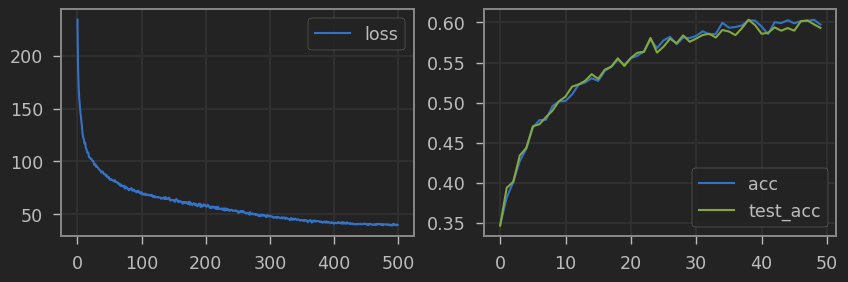

In [122]:
fig = plt.figure(figsize=(10, 3), dpi=100)
ax = plt.subplot(1, 2, 1)
ax.plot(hist['loss'])
ax.legend(['loss'])
ax.grid(True)
ax = plt.subplot(1, 2, 2)
ax.plot(hist['acc'])
ax.plot(hist['test_acc'])
ax.legend(['acc', 'test_acc'])
ax.grid(True)
plt.show()

Como puedes ver, a medida que entrenamos la *backbone* de manera no supervisada, la precisión que obtenemos al usarla para clasificación mejora. Ésto nos indica que, efectivamente, la red está aprendiendo a extraer las características visuales necesarias de nuestras imágenes.

Vamos a terminar usando nuestra *backbone* con diferentes porcentages de etiquetas para comparar los resultados con los obtenidos anteriormente.

In [123]:
torch.jit.script(SSLmodel.backbone.cpu()).save('SSLbackbone.pt')

In [129]:
pctgs = [0.01, 0.1, 1.]
batch_size = 1024
epochs=3
lr=1e-3
ssl_hists = []
for pctg in pctgs:
    ds = {
        'train': Dataset(pctg=pctg),
        'test': Dataset(train=False)
    }
    dl = {
        'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    } 
    FTmodel = FTModel()
    optimizer = torch.optim.Adam(FTmodel.parameters(), lr=lr)
    hist = train(FTmodel, dl, optimizer, epochs=epochs)
    ssl_hists.append(hist)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/3 loss 9.7609 acc 0.1060 test_loss 6.3200 test_acc 0.1132


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/3 loss 6.2254 acc 0.1200 test_loss 5.5854 test_acc 0.1292


testing... loss 5.7344 acc 0.0980: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Epoch 3/3 loss 5.3431 acc 0.1280 test_loss 5.7344 test_acc 0.0980
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/3 loss 7.5368 acc 0.0974 test_loss 5.6254 test_acc 0.1173


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/3 loss 4.7035 acc 0.1323 test_loss 3.8028 test_acc 0.1819


testing... loss 2.8816 acc 0.2850: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


Epoch 3/3 loss 3.3998 acc 0.2389 test_loss 2.8816 test_acc 0.2850
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/3 loss 2.8877 acc 0.3878 test_loss 1.4003 test_acc 0.5542


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/3 loss 1.2877 acc 0.5780 test_loss 1.2324 test_acc 0.5885


testing... loss 1.1488 acc 0.6008: 100%|██████████| 10/10 [00:01<00:00,  6.80it/s]

Epoch 3/3 loss 1.1739 acc 0.5990 test_loss 1.1488 test_acc 0.6008


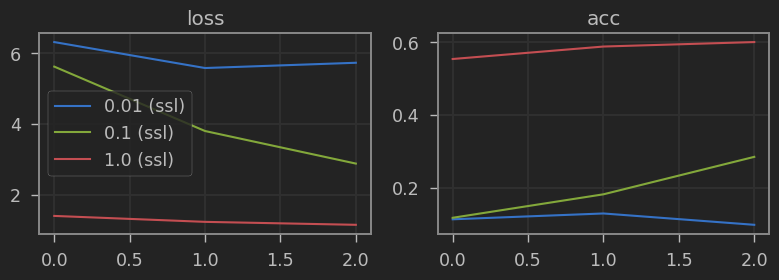

In [130]:
fig = plt.figure(figsize=(8, 3), dpi=100)
ax = plt.subplot(1, 2, 1)
for i, pctg in enumerate(pctgs):
    ax.plot(ssl_hists[i]['test_loss'], label=f'{pctg} (ssl)')
ax.grid(True)
ax.legend()
ax.set_title('loss')
ax = plt.subplot(1, 2, 2)
for i, pctg in enumerate(pctgs):
    ax.plot(ssl_hists[i]['test_acc'])
ax.grid(True)
ax.set_title('acc')
plt.tight_layout()
plt.show()
# 12, 22, 44
# 13, 28, 60

¡Estupendo! Nuestro modelo es ligeramente mejor que si usamos los pesos entrenados de Imagenet, pero el hecho de que sea al menos comparable ya es una muy buena noticia. Además, nos da mucho mejor resultado si usamos el 1% o 10% de las etiquetas comparado con el modelo entrenado desde cero. Puedes usar esta técnica a partir de ahora cuando tengas un dataset anotado pequeño pero dispongas de muchos más ejemplos sin anotar, o te sea fácil conseguirlos. Tus modelos mejorarán considerablemente.

## Resumen

Disponer de una red pre-entrenada capaz de extraer representaciones útiles para tareas de visión por computador nos da una eficiencia de datos mucho mayor, requiriendo de menos datos etiquetados y menor coste computacional para obtener resultados aceptables. Si bien lo más común es utilizar una red pre-entrenada con el dataset Imagenet, existen muchas aplicaciones en las que las características visuales de las imágenes son diferentes (como por ejemplo imágenes médicas o por satélite). En estos casos, el tener redes pre-entrenadas en los datos propios del dominio de aplicación nos puede dar muchos mejores resultados. Además, en estas aplicaciones en particular, elaborar datasets de calidad y con muchos ejemplos es muy costoso. Tener modelos capaces de dar buenos resultados con pocas muestras nos da mucha ventaja. El campo *self-supervised learning* se enfoca precisamente en resolver estos problemas y cada vez más podemos ver que se utiliza en el pre-entrenamiento de redes neuronales enormes con datasets no etiquetas consistenes en millones de millones de muestras, que luego son *fine tuneadas* a tareas concretas con datasets etiquetados dando mejores resultados que si tuviésemos que entrenar desde cero.

## Recursos

Aprende más sobre SSL con estos vídeos:
    
- [https://www.youtube.com/watch?v=7QmsTleiRLs](https://www.youtube.com/watch?v=7QmsTleiRLs)
- [https://www.youtube.com/watch?v=0KeR6i1_56g](https://www.youtube.com/watch?v=0KeR6i1_56g)